# Exploratory notebook: get familiarized with JOW/Agribalyse databases and see how to match them

- **Input JOW data** (scrapped by Eliott): 
    - "../data/Recipes/recipes_jow.json" 
- **Input Agribalyse data** (downloaded on https://doc.agribalyse.fr/documentation/acces-donnees): 
    - "../data/Agribalyse/AGRIBALYSE3.1_partie agriculture_conv_vf.xlsx" (products leaving the farms)
    - "../data/Agribalyse/AGRIBALYSE3.1_produits alimentaires_2.xlsm" (industrials products after transformation, transport, packaging, ...)
    
**Inspired by previous Eliott's notebook '[Eliott] recipes_footprints'**

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Let's look at Agribalyse raw data

#### Look first at "../data/Agribalyse/AGRIBALYSE3.1_partie agriculture_conv_vf"

In [2]:
data_AGB_farm = pd.read_excel("../data/Agribalyse/AGRIBALYSE3.1_partie agriculture_conv_vf.xlsx", \
                                     sheet_name = 'AGB_agri_conv', skiprows = 1, header = [0 ,1])

In [3]:
data_AGB_farm.head(3)

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Score unique EF3.1,Changement climatique,Appauvrissement de la couche d'ozone,Rayonnements ionisants,Formation photochimique d'ozone,Particules,Effets toxicologiques sur la santé humaine : substances non-cancérogènes*,Effets toxicologiques sur la santé humaine : substances cancérogènes*,Acidification terrestre et eaux douces,Eutrophisation eaux douces,Eutrophisation marine,Eutrophisation terreste,Écotoxicité pour écosystèmes aquatiques d'eau douce,Utilisation du sol,Épuisement des ressources eau,Épuisement des ressources énergétiques,Épuisement des ressources minéraux
,Nom du Produit en Français (traduction approximative GoogleTranslate),LCI Name,Catégorie,mPt/kg,kg CO2 eq/kg,kg CFC11 eq/kg,kBq U-235 eq/kg,kg NMVOC eq/kg,disease inc./kg,CTUh/kg,CTUh/kg,mol H+ eq/kg,kg P eq/kg,kg N eq/kg,mol N eq/kg,CTUe/kg,Pt/kg,m3 depriv./kg,MJ/kg,kg Sb eq/kg
0,"Agneau système de production conventionnel, in...","Lamb, conventional, indoor production system, ...",Agricultural\Animal production\Ovine\Transform...,1.861962,16.260055,3.812082e-07,0.384010,0.025777,1.971493e-06,3.151420e-07,8.673159e-09,0.291614,0.001083,0.063427,1.291483,75.263604,1772.330900,5.034850,36.407330,0.000024
1,"Agneau, conventionnel, système Roquefort, à la...","Lamb, conventional, Roquefort system, at farm ...",Agricultural\Animal production\Ovine\Transform...,0.584921,4.343651,1.087468e-07,0.226843,0.005949,7.182928e-07,5.785546e-08,1.952941e-09,0.104941,0.000236,0.021571,0.465543,15.864931,507.664910,0.690593,12.829857,0.000006
2,"Algue production non optimisée, 1 kg d'algues ...","Seaweed non-optimized production, 1kg algae (L...",Agricultural\Plant production\Other\Transforma...,0.124275,0.847301,1.506487e-07,0.170081,0.005215,1.169689e-07,1.062670e-08,9.602334e-10,0.016369,0.000269,0.001661,0.016217,7.714319,2.935613,0.498027,15.473219,0.000014


Rename the columns (but keep in mind the units!)  
Note there is no columns for the Data Quality Ratio (DQR).

In [4]:
data_AGB_farm.columns[0]

('Unnamed: 0_level_0',
 'Nom du Produit en Français (traduction approximative GoogleTranslate)')

In [5]:
# Flatten the MultiIndex into a Single Index
data_AGB_farm.columns = ['_'.join(col) if type(col) is tuple else col for col in data_AGB_farm.columns.values]
data_AGB_farm.head(2)

,Unnamed: 0_level_0_Nom du Produit en Français (traduction approximative GoogleTranslate),Unnamed: 1_level_0_LCI Name,Unnamed: 2_level_0_Catégorie,Score unique EF3.1 _mPt/kg,Changement climatique_kg CO2 eq/kg,Appauvrissement de la couche d'ozone _kg CFC11 eq/kg,Rayonnements ionisants _kBq U-235 eq/kg,Formation photochimique d'ozone _kg NMVOC eq/kg,Particules _disease inc./kg,Effets toxicologiques sur la santé humaine : substances non-cancérogènes*_CTUh/kg,Effets toxicologiques sur la santé humaine : substances cancérogènes*_CTUh/kg,Acidification terrestre et eaux douces_mol H+ eq/kg,Eutrophisation eaux douces _kg P eq/kg,Eutrophisation marine _kg N eq/kg,Eutrophisation terreste_mol N eq/kg,Écotoxicité pour écosystèmes aquatiques d'eau douce_CTUe/kg,Utilisation du sol_Pt/kg,Épuisement des ressources eau_m3 depriv./kg,Épuisement des ressources énergétiques_MJ/kg,Épuisement des ressources minéraux_kg Sb eq/kg
0,"Agneau système de production conventionnel, in...","Lamb, conventional, indoor production system, ...",Agricultural\Animal production\Ovine\Transform...,1.861962,16.260055,3.812082e-07,0.384010,0.025777,1.971493e-06,3.151420e-07,8.673159e-09,0.291614,0.001083,0.063427,1.291483,75.263604,1772.33090,5.034850,36.407330,0.000024
1,"Agneau, conventionnel, système Roquefort, à la...","Lamb, conventional, Roquefort system, at farm ...",Agricultural\Animal production\Ovine\Transform...,0.584921,4.343651,1.087468e-07,0.226843,0.005949,7.182928e-07,5.785546e-08,1.952941e-09,0.104941,0.000236,0.021571,0.465543,15.864931,507.66491,0.690593,12.829857,0.000006


In [6]:
old_col_names = data_AGB_farm.columns

new_col_names = ['Nom produit',    # Nom du Produit en Français (traduction approximative GoogleTranslate)
                 'LCI name', 
                 'Catégorie', 
                 'PEF',            # Score unique EF3.1 (mPt/kg)
                 'CO2',            # Changement climatique (kg CO2 eq/kg)
                 'Ozone_1',        # Appauvrissement de la couche d'ozone (kg CFC11 eq/kg)
                 'Rad',            # Rayonnements ionisants (kBq U-235 eq/kg)
                 'Ozone_2',        # Formation photochimique d'ozone (kg NMVOC eq/kg)
                 'Particules',     # Particules (disease inc./kg)
                 'Toxic_1',        # Effets toxicologiques sur la santé humaine : substances non-cancérogènes (CTUh/kg)
                 'Toxic_2',        # Effets toxicologiques sur la santé humaine : substances cancérogènes (CTUh/kg)
                 'Acid',           # Acidification terrestre et eaux douces (mol H+ eq/kg)
                 'Eutro_1',        # Eutrophisation eaux douces (kg P eq/kg)
                 'Eutro_2',        # Eutrophisation marine (kg N eq/kg)
                 'Eutro_3',        # Eutrophisation terrestre (mol N eq/kg)
                 'Ecotoxic',       # Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg)
                 'Sol',            # Utilisation du sol (Pt/kg)
                 'Ressource_1',    # Épuisement des ressources eau (m3 depriv./kg)
                 'Ressource_2',    # Épuisement des ressources énergétiques (MJ/kg)
                 'Ressource_3'     # Épuisement des ressources minéraux (kg Sb eq/kg)
                ]

dict_col_rename = {}
for i in range(len(old_col_names)):
    dict_col_rename[old_col_names[i]] = new_col_names[i]
    
data_AGB_farm = data_AGB_farm.rename(columns = dict_col_rename)

In [7]:
data_AGB_farm.head(3)

,Nom produit,LCI name,Catégorie,PEF,CO2,Ozone_1,Rad,Ozone_2,Particules,Toxic_1,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,"Agneau système de production conventionnel, in...","Lamb, conventional, indoor production system, ...",Agricultural\Animal production\Ovine\Transform...,1.861962,16.260055,3.812082e-07,0.384010,0.025777,1.971493e-06,3.151420e-07,8.673159e-09,0.291614,0.001083,0.063427,1.291483,75.263604,1772.330900,5.034850,36.407330,0.000024
1,"Agneau, conventionnel, système Roquefort, à la...","Lamb, conventional, Roquefort system, at farm ...",Agricultural\Animal production\Ovine\Transform...,0.584921,4.343651,1.087468e-07,0.226843,0.005949,7.182928e-07,5.785546e-08,1.952941e-09,0.104941,0.000236,0.021571,0.465543,15.864931,507.664910,0.690593,12.829857,0.000006
2,"Algue production non optimisée, 1 kg d'algues ...","Seaweed non-optimized production, 1kg algae (L...",Agricultural\Plant production\Other\Transforma...,0.124275,0.847301,1.506487e-07,0.170081,0.005215,1.169689e-07,1.062670e-08,9.602334e-10,0.016369,0.000269,0.001661,0.016217,7.714319,2.935613,0.498027,15.473219,0.000014


In [8]:
data_AGB_farm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nom produit  259 non-null    object 
 1   LCI name     259 non-null    object 
 2   Catégorie    259 non-null    object 
 3   PEF          259 non-null    float64
 4   CO2          259 non-null    float64
 5   Ozone_1      259 non-null    float64
 6   Rad          259 non-null    float64
 7   Ozone_2      259 non-null    float64
 8   Particules   259 non-null    float64
 9   Toxic_1      259 non-null    float64
 10  Toxic_2      259 non-null    float64
 11  Acid         259 non-null    float64
 12  Eutro_1      259 non-null    float64
 13  Eutro_2      259 non-null    float64
 14  Eutro_2      259 non-null    float64
 15  Ecotoxic     259 non-null    float64
 16  Sol          259 non-null    float64
 17  Ressource_1  259 non-null    float64
 18  Ressource_2  259 non-null    float64
 19  Ressourc

In [9]:
data_AGB_farm.isna().sum().sum()

0

There are 259 ingredients and no missing values.

**Let's look now at score distributions**

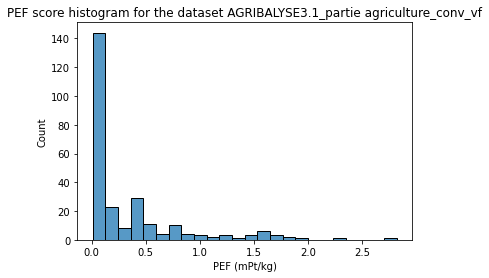

In [10]:
plt.title("PEF score histogram for the dataset AGRIBALYSE3.1_partie agriculture_conv_vf")
plt.xlabel("PEF (mPt/kg)")
sns.histplot(data_AGB_farm['PEF']);

What are the best and worse ingredients in terms of PEF?

In [11]:
data_AGB_farm.sort_values(by=['PEF'])

,Nom produit,LCI name,Catégorie,PEF,CO2,Ozone_1,Rad,Ozone_2,Particules,Toxic_1,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
10,"Betteraves, moyen conventionnel, national, ali...","Sugar beet roots, conventional, national avera...",Agricultural\Plant production\Roots and tubers...,0.006623,0.038559,2.124967e-09,0.001821,0.000119,4.021476e-09,2.640036e-09,6.432518e-11,0.000600,0.000009,0.000295,0.002688,2.284910,7.458146,0.069585,0.198881,1.765417e-07
26,"Carotte, conventionnel, fall, Mont St. Michel,...","Carrot, conventional, fall, Mont St. Michel, L...",Agricultural\Plant production\Vegetables\Trans...,0.007699,0.047323,6.468192e-09,0.003518,0.000279,3.194284e-09,1.348151e-09,6.950073e-11,0.000533,0.000012,0.000463,0.002117,3.436435,5.687183,0.043406,0.561438,4.487387e-07
27,"Carotte, conventionnel, fall, Val de Saire, Ba...","Carrot, conventional, fall, Val de Saire, Lowe...",Agricultural\Plant production\Vegetables\Trans...,0.007829,0.046820,6.369664e-09,0.003727,0.000297,3.357798e-09,1.256285e-09,7.471799e-11,0.000572,0.000013,0.000582,0.002277,2.744309,6.759221,0.046551,0.519932,4.371681e-07
25,"Carotte, conventionnel, fall, Creances, Basse-...","Carrot, conventional, fall, Creances, Lower No...",Agricultural\Plant production\Vegetables\Trans...,0.009773,0.048395,6.987125e-09,0.006563,0.000265,3.513154e-09,1.106242e-09,7.458529e-11,0.000534,0.000015,0.000362,0.002000,4.025281,6.031303,0.268313,0.650906,5.498683e-07
31,"Carotte, conventionnel, hiver, Val de Saire, B...","Carrot, conventional, winter, Val de Saire, Lo...",Agricultural\Plant production\Vegetables\Trans...,0.009855,0.059661,9.418634e-09,0.004975,0.000387,3.966270e-09,1.486370e-09,7.643242e-11,0.000682,0.000014,0.000590,0.002668,5.182326,5.036218,0.060275,0.717205,5.800886e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,"Vache allaitante de réforme, conventionnel, va...","Suckler cull cow, conventional, suckler cow sy...",Agricultural\Animal production\Bovine\Transfor...,1.798186,18.727678,3.516632e-07,0.496019,0.026002,1.697015e-06,3.341046e-07,9.358419e-09,0.252791,0.000985,0.045660,1.115914,45.462003,1977.020600,2.995505,41.126228,3.348064e-05
0,"Agneau système de production conventionnel, in...","Lamb, conventional, indoor production system, ...",Agricultural\Animal production\Ovine\Transform...,1.861962,16.260055,3.812082e-07,0.384010,0.025777,1.971493e-06,3.151420e-07,8.673159e-09,0.291614,0.001083,0.063427,1.291483,75.263604,1772.330900,5.034850,36.407330,2.358424e-05
19,"Brebis de réforme, conventionnel, intérieur, à...","Cull ewe, conventional, indoor production syst...",Agricultural\Animal production\Ovine\Transform...,1.908155,18.147478,3.775023e-07,0.290375,0.026538,1.976821e-06,3.036811e-07,8.736347e-09,0.294088,0.000997,0.071114,1.304120,65.791080,1780.602600,2.445968,34.676828,2.593374e-05
186,"Poule de réforme, conventionnel, intérieur, ca...","Cull hen, conventional, indoor production, cag...",Agricultural\Animal production\Avian\Transform...,2.248782,13.862278,6.355994e-07,1.143978,0.032208,2.578675e-06,2.373513e-07,1.408637e-08,0.372652,0.002901,0.071379,1.625544,320.967950,856.590190,14.072982,82.205626,4.501917e-05


In [12]:
data_AGB_farm['Catégorie'].unique()

array(['Agricultural\\Animal production\\Ovine\\Transformation',
       'Agricultural\\Plant production\\Other\\Transformation',
       'Agricultural\\Plant production\\Fruits\\Transformation',
       'Agricultural\\Animal production\\Fish\\Transformation',
       'Agricultural\\Plant production\\Cereals\\Transformation',
       'Agricultural\\Plant production\\Vegetables\\Transformation',
       'Agricultural\\Plant production\\Roots and tubers\\Transformation',
       'Agricultural\\Animal production\\Bovine\\Transformation',
       'Agricultural\\Animal production\\Avian\\Transformation',
       'Agricultural\\Animal production\\Caprine\\Transformation',
       'Agricultural\\Plant production\\Oil seeds\\Transformation',
       'Agricultural\\Plant production\\Legumes\\Transformation',
       'Agricultural\\Animal production\\Seafood\\Transformation',
       'Agricultural\\Animal production\\Dairy\\Transformation',
       'Agricultural\\Animal production\\Other\\Transformation',
   

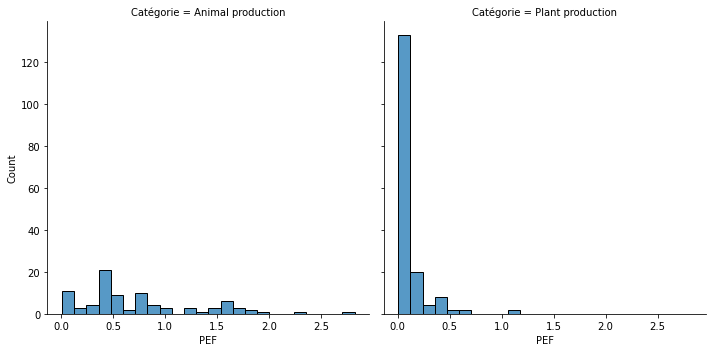

In [13]:
data_AGB_farm_2categories = data_AGB_farm.copy()
data_AGB_farm_2categories['Catégorie'] = data_AGB_farm['Catégorie'].apply(lambda x: x.split('\\')[1])

sns.displot(data = data_AGB_farm_2categories, x = 'PEF', kind = 'hist', col = 'Catégorie');


In [14]:
data_AGB_farm_NomProdSimple = data_AGB_farm.copy()
data_AGB_farm_NomProdSimple['Nom produit'] = data_AGB_farm_NomProdSimple['Nom produit'].apply(lambda x: x.split(',')[0])
data_AGB_farm_NomProdSimple = data_AGB_farm_NomProdSimple.rename({'Nom produit': 'Nom produit simple'}, axis = 1)
data_AGB_farm_NomProdSimple.head(5)

,Nom produit simple,LCI name,Catégorie,PEF,CO2,Ozone_1,Rad,Ozone_2,Particules,Toxic_1,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,Agneau système de production conventionnel,"Lamb, conventional, indoor production system, ...",Agricultural\Animal production\Ovine\Transform...,1.861962,16.260055,3.812082e-07,0.384010,0.025777,1.971493e-06,3.151420e-07,8.673159e-09,0.291614,0.001083,0.063427,1.291483,75.263604,1772.330900,5.034850,36.407330,2.358424e-05
1,Agneau,"Lamb, conventional, Roquefort system, at farm ...",Agricultural\Animal production\Ovine\Transform...,0.584921,4.343651,1.087468e-07,0.226843,0.005949,7.182928e-07,5.785546e-08,1.952941e-09,0.104941,0.000236,0.021571,0.465543,15.864931,507.664910,0.690593,12.829857,6.261006e-06
2,Algue production non optimisée,"Seaweed non-optimized production, 1kg algae (L...",Agricultural\Plant production\Other\Transforma...,0.124275,0.847301,1.506487e-07,0.170081,0.005215,1.169689e-07,1.062670e-08,9.602334e-10,0.016369,0.000269,0.001661,0.016217,7.714319,2.935613,0.498027,15.473219,1.410668e-05
3,Algue production optimisée,"Optimized seaweed production, 1kg algae (Lamin...",Agricultural\Plant production\Other\Transforma...,0.011687,0.101435,8.726019e-09,0.024856,0.000704,8.763355e-09,5.707872e-10,1.322074e-10,0.001000,0.000021,0.000253,0.002433,0.286383,0.287014,0.057395,2.098933,4.606886e-07
4,Ananas,"Pineapple, mixed production, Reunion Island av...",Agricultural\Plant production\Fruits\Transform...,0.094164,0.867768,3.080570e-08,0.020339,0.002294,1.149442e-07,1.796827e-09,9.500784e-11,0.010308,0.000022,0.006681,0.069733,2.686393,25.756989,0.544602,2.904503,1.260082e-06


In [15]:
data_AGB_farm_NomProdSimple['Nom produit simple'].unique().shape

(121,)

When we consider only the first noun (before the first comma) appearing in each entry of the column 'Nom Produit', how big are the fluctuations of the PEF score for a given simplied 'Nom produit'?

In [16]:
data_tmp = data_AGB_farm_NomProdSimple.groupby('Nom produit simple')['PEF']\
                            .agg(['mean', 'std', 'count'])\
                            .sort_values(by = 'std', ascending = False)

data_tmp.head(10)

,mean,std,count
Nom produit simple,,,
Brebis de réforme,1.450717,0.646916,2
Poule de réforme,1.133018,0.625190,5
Saithe,0.575872,0.261446,2
Riz thaï,0.621201,0.257088,6
Vache de réforme,1.086977,0.204837,4
Vache allaitante de réforme,1.654656,0.202983,2
Tourteau,0.729676,0.200092,3
Dinde,0.656570,0.149011,3
Taurillon allaitant,1.568841,0.110554,2


In [17]:
data_AGB_farm_NomProdSimple[data_AGB_farm_NomProdSimple['Nom produit simple']=='Poule de réforme']

,Nom produit simple,LCI name,Catégorie,PEF,CO2,Ozone_1,Rad,Ozone_2,Particules,Toxic_1,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
185,Poule de réforme,"Cull hen, conventional, indoor system, non-cag...",Agricultural\Animal production\Avian\Transform...,0.900410,6.341931,3.650608e-07,0.795061,0.014378,9.018453e-07,9.854736e-08,6.322861e-09,0.129690,0.001226,0.027647,0.558848,129.92974,343.50279,5.605673,54.102830,0.000022
186,Poule de réforme,"Cull hen, conventional, indoor production, cag...",Agricultural\Animal production\Avian\Transform...,2.248782,13.862278,6.355994e-07,1.143978,0.032208,2.578675e-06,2.373513e-07,1.408637e-08,0.372652,0.002901,0.071379,1.625544,320.96795,856.59019,14.072982,82.205626,0.000045
187,Poule de réforme,"Cull hen, conventional, indoor system, cage, a...",Agricultural\Animal production\Avian\Transform...,0.804605,5.699239,3.307056e-07,0.724143,0.012901,8.006476e-07,8.820645e-08,5.677826e-09,0.115102,0.001098,0.024664,0.495657,116.16318,306.97604,5.008121,49.206065,0.000020
188,Poule de réforme,"Cull hen, conventional, national average, at f...",Agricultural\Animal production\Avian\Transform...,0.818984,5.795182,3.357831e-07,0.734537,0.013122,8.159116e-07,8.975846e-08,5.774269e-09,0.117303,0.001117,0.025114,0.505197,118.23168,312.46777,5.097991,49.925456,0.000020
189,Poule de réforme,"Cull hen, conventional, outdoor system, at far...",Agricultural\Animal production\Avian\Transform...,0.892309,6.284872,3.617763e-07,0.787907,0.014249,8.937314e-07,9.766073e-08,6.265974e-09,0.128523,0.001215,0.027398,0.553820,128.76076,340.41229,5.555239,53.616063,0.000021


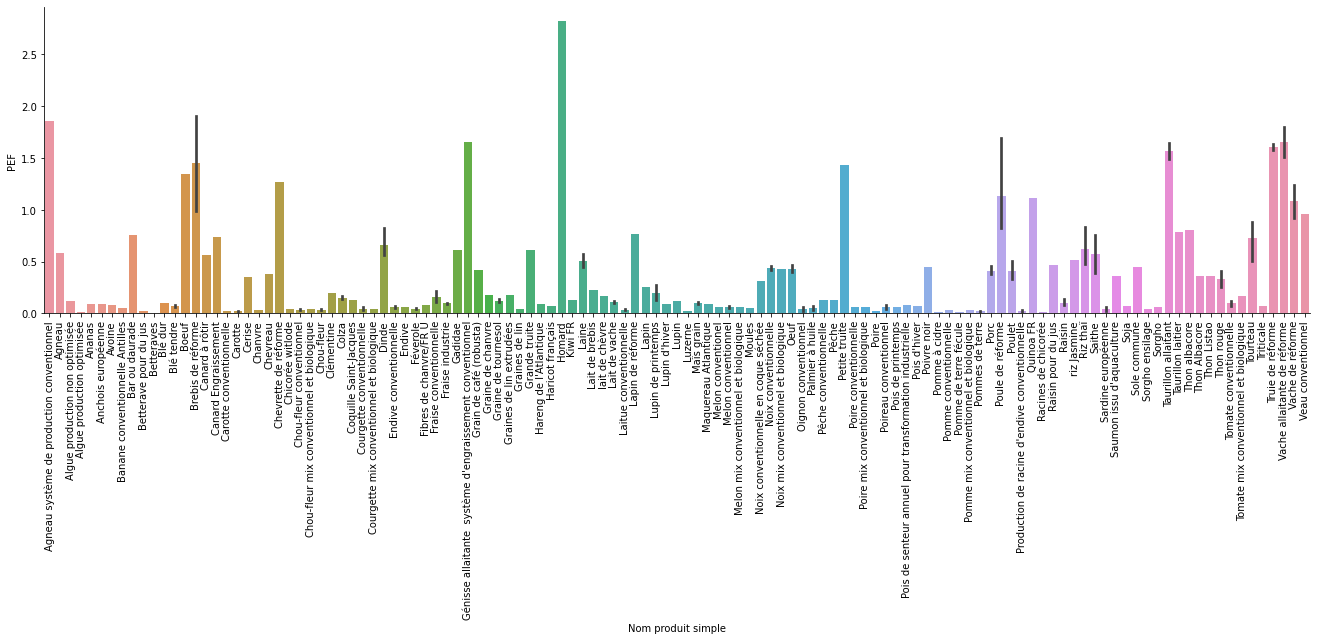

In [18]:
fig = sns.catplot(data = data_AGB_farm_NomProdSimple, x = 'Nom produit simple', y = 'PEF', kind = 'bar', aspect = 4)
fig.set_xticklabels(rotation=90);

When there is more than one entry for a (simplified) ingredient name, the error bar is often - but not always - negligible, see e.g. "Brebis de réforme", "Dinde", "Poule de réforme"...

### Repeat the study for "../data/Agribalyse/AGRIBALYSE3.1_produits alimentaires_2.xlsm"  
Note there are 2 interesting sheets:  
- "Synthese" : for individual ingredients
- "Detail ingredient": for recipes

The columns are not exactly the same for the 2 sheets.

#### Let's start with the sheet 'Synthese'

In [19]:
data_AGB_prod = pd.read_excel("../data/Agribalyse/AGRIBALYSE3.1_produits alimentaires_2.xlsm", \
                                     sheet_name = 'Synthese', skiprows = 1, header = [0 ,1])

In [20]:
data_AGB_prod.head(2)

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,Unnamed: 4_level_0,Unnamed: 5_level_0,Unnamed: 6_level_0,Unnamed: 7_level_0,Unnamed: 8_level_0,Unnamed: 9_level_0,...,Effets toxicologiques sur la santé humaine : substances cancérogènes,Acidification terrestre et eaux douces,Eutrophisation eaux douces,Eutrophisation marine,Eutrophisation terrestre,Écotoxicité pour écosystèmes aquatiques d'eau douce,Utilisation du sol,Épuisement des ressources eau,Épuisement des ressources énergétiques,Épuisement des ressources minéraux
,Code\nAGB,Code\nCIQUAL,Groupe d'aliment,Sous-groupe d'aliment,Nom du Produit en Français,LCI Name,code saison (0 : hors saison ; 1 : de saison ; 2 : mix de consommation FR),code avion (1 : par avion),Livraison,Matériau d'emballage,...,CTUh/kg de produit,mol H+ eq/kg de produit,kg P eq/kg de produit,kg N eq/kg de produit,mol N eq/kg de produit,CTUe/kg de produit,Pt/kg de produit,m3 depriv./kg de produit,MJ/kg de produit,kg Sb eq/kg de produit
0,11084,11084,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.01328,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088
1,11023,11023,aides culinaires et ingrédients divers,herbes,"Ail séché, poudre","Garlic, powder, dried",2,0,Ambiant (long),Verre,...,4.662163e-10,0.006222,0.000124,0.00232,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007


Rename the columns

In [21]:
# Flatten the MultiIndex into a Single Index
data_AGB_prod.columns = ['_'.join(col) if type(col) is tuple else col for col in data_AGB_prod.columns.values]
data_AGB_prod.head(2)

,Unnamed: 0_level_0_Code\nAGB,Unnamed: 1_level_0_Code\nCIQUAL,Unnamed: 2_level_0_Groupe d'aliment,Unnamed: 3_level_0_Sous-groupe d'aliment,Unnamed: 4_level_0_Nom du Produit en Français,Unnamed: 5_level_0_LCI Name,Unnamed: 6_level_0_code saison (0 : hors saison ; 1 : de saison ; 2 : mix de consommation FR),Unnamed: 7_level_0_code avion (1 : par avion),Unnamed: 8_level_0_Livraison,Unnamed: 9_level_0_Matériau d'emballage,...,Effets toxicologiques sur la santé humaine : substances cancérogènes_CTUh/kg de produit,Acidification terrestre et eaux douces_mol H+ eq/kg de produit,Eutrophisation eaux douces_kg P eq/kg de produit,Eutrophisation marine_kg N eq/kg de produit,Eutrophisation terrestre_mol N eq/kg de produit,Écotoxicité pour écosystèmes aquatiques d'eau douce_CTUe/kg de produit,Utilisation du sol_Pt/kg de produit,Épuisement des ressources eau_m3 depriv./kg de produit,Épuisement des ressources énergétiques_MJ/kg de produit,Épuisement des ressources minéraux_kg Sb eq/kg de produit
0,11084,11084,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.01328,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088
1,11023,11023,aides culinaires et ingrédients divers,herbes,"Ail séché, poudre","Garlic, powder, dried",2,0,Ambiant (long),Verre,...,4.662163e-10,0.006222,0.000124,0.00232,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007


In [22]:
old_col_names = data_AGB_prod.columns

new_col_names = ['Code AGB',
                 'Code CIQUAL',
                 'Groupe',
                 'Sous-groupe',
                 'Nom produit',    # Nom du Produit en Français (traduction approximative GoogleTranslate)
                 'LCI name', 
                 'Code saison',
                 'Code avion',
                 'Livraison',
                 'Emballage',
                 'Préparation',
                 'DQR', 
                 'PEF',            # Score unique EF3.1 (mPt/kg)
                 'CO2',            # Changement climatique (kg CO2 eq/kg)
                 'Ozone_1',        # Appauvrissement de la couche d'ozone (kg CFC11 eq/kg)
                 'Rad',            # Rayonnements ionisants (kBq U-235 eq/kg)
                 'Ozone_2',        # Formation photochimique d'ozone (kg NMVOC eq/kg)
                 'Particules',     # Particules (disease inc./kg)
                 'Toxic_1',        # Effets toxicologiques sur la santé humaine : substances non-cancérogènes (CTUh/kg)
                 'Toxic_2',        # Effets toxicologiques sur la santé humaine : substances cancérogènes (CTUh/kg)
                 'Acid',           # Acidification terrestre et eaux douces (mol H+ eq/kg)
                 'Eutro_1',        # Eutrophisation eaux douces (kg P eq/kg)
                 'Eutro_2',        # Eutrophisation marine (kg N eq/kg)
                 'Eutro_2',        # Eutrophisation terrestre (mol N eq/kg)
                 'Ecotoxic',       # Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg)
                 'Sol',            # Utilisation du sol (Pt/kg)
                 'Ressource_1',    # Épuisement des ressources eau (m3 depriv./kg)
                 'Ressource_2',    # Épuisement des ressources énergétiques (MJ/kg)
                 'Ressource_3'     # Épuisement des ressources minéraux (kg Sb eq/kg)
                ]


dict_col_rename = {}
for i in range(len(old_col_names)):
    dict_col_rename[old_col_names[i]] = new_col_names[i]
    
data_AGB_prod = data_AGB_prod.rename(columns = dict_col_rename)

In [23]:
data_AGB_prod.head(2)

,Code AGB,Code CIQUAL,Groupe,Sous-groupe,Nom produit,LCI name,Code saison,Code avion,Livraison,Emballage,...,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,11084,11084,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.01328,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088
1,11023,11023,aides culinaires et ingrédients divers,herbes,"Ail séché, poudre","Garlic, powder, dried",2,0,Ambiant (long),Verre,...,4.662163e-10,0.006222,0.000124,0.00232,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007


Are the columns "Code AGB" and "Code CIQUAL" different? Apparently yes, slightly, let's keep them both.

In [24]:
data_AGB_prod.loc[np.where(data_AGB_prod['Code AGB'].apply(int)!=data_AGB_prod['Code CIQUAL'])[0].tolist()].head(2)


,Code AGB,Code CIQUAL,Groupe,Sous-groupe,Nom produit,LCI name,Code saison,Code avion,Livraison,Emballage,...,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
443,25415_2,25415,entrées et plats composés,sandwichs,Burger végétarien,Veggie burger,2,0,Glacé,LDPE,...,1.971148e-09,0.022188,0.000444,0.010083,0.087518,27.224499,126.44897,1.396874,56.703059,0.000014
479,25415_1,25415,entrées et plats composés,sandwichs,"Double cheeseburger, provenant de fast food","Cheeseburger, double, from fast foods restaurant",2,0,Glacé,PS,...,6.912349e-09,0.171413,0.000983,0.042842,0.748660,74.854240,879.56691,3.472435,68.490494,0.000030


In [25]:
data_AGB_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Code AGB     2517 non-null   object 
 1   Code CIQUAL  2517 non-null   int64  
 2   Groupe       2517 non-null   object 
 3   Sous-groupe  2517 non-null   object 
 4   Nom produit  2517 non-null   object 
 5   LCI name     2517 non-null   object 
 6   Code saison  2517 non-null   int64  
 7   Code avion   2517 non-null   int64  
 8   Livraison    2517 non-null   object 
 9   Emballage    2517 non-null   object 
 10  Préparation  2517 non-null   object 
 11  DQR          2517 non-null   float64
 12  PEF          2517 non-null   float64
 13  CO2          2517 non-null   float64
 14  Ozone_1      2517 non-null   float64
 15  Rad          2517 non-null   float64
 16  Ozone_2      2517 non-null   float64
 17  Particules   2517 non-null   float64
 18  Toxic_1      2517 non-null   float64
 19  Toxic_

In [26]:
data_AGB_farm.isna().sum().sum()

0

There are 2517 ingredients and no missing values.

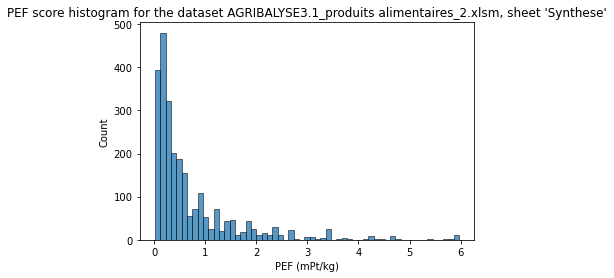

In [27]:
plt.title("PEF score histogram for the dataset AGRIBALYSE3.1_produits alimentaires_2.xlsm, sheet 'Synthese'")
plt.xlabel("PEF (mPt/kg)")
sns.histplot(data_AGB_prod['PEF']);

What are the best and worse ingredients in terms of PEF?

In [28]:
data_AGB_prod.sort_values(by=['PEF'])[['Nom produit', 'PEF']]

,Nom produit,PEF
409,"Tisane infusée, non sucrée",0.012978
408,"Thé vert, infusé, non sucré",0.012978
407,"Thé oolong, infusé, non sucré",0.012978
406,"Thé noir, infusé, non sucré",0.012978
405,"Thé infusé, non sucré",0.012978
...,...,...
1968,Brochette d'agneau,5.960346
1888,"Agneau, gigot, rôti/cuit au four",5.974454
1891,"Agneau, selle, partie maigre, rôtie/cuite au four",5.974454
1885,"Agneau, gigot, braisé",5.974454


In [29]:
data_AGB_prod_NomProdSimple = data_AGB_prod.copy()
data_AGB_prod_NomProdSimple['Nom produit'] = data_AGB_prod_NomProdSimple['Nom produit'].apply(lambda x: x.split(',')[0])
data_AGB_prod_NomProdSimple = data_AGB_prod_NomProdSimple.rename({'Nom produit': 'Nom produit simple'}, axis = 1)
data_AGB_prod_NomProdSimple.head(5)

,Code AGB,Code CIQUAL,Groupe,Sous-groupe,Nom produit simple,LCI name,Code saison,Code avion,Livraison,Emballage,...,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,11084,11084,aides culinaires et ingrédients divers,algues,Agar (algue),"Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.013280,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088
1,11023,11023,aides culinaires et ingrédients divers,herbes,Ail séché,"Garlic, powder, dried",2,0,Ambiant (long),Verre,...,4.662163e-10,0.006222,0.000124,0.002320,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007
2,11000,11000,aides culinaires et ingrédients divers,herbes,Ail,"Garlic, fresh",2,0,Ambiant (long),Pas d'emballage,...,2.984758e-10,0.002005,0.000068,0.002123,0.006281,4.092332,18.454615,3.021753,6.230187,0.000004
3,11093,11093,aides culinaires et ingrédients divers,herbes,Aneth,"Dill, fresh",2,0,Ambiant (long),LDPE,...,6.189716e-10,0.008112,0.000203,0.004050,0.031181,5.681342,36.373722,5.292121,12.553109,0.000005
4,20995,20995,aides culinaires et ingrédients divers,algues,Ao-nori (Enteromorpha sp.),"Sea lettuce (Enteromorpha sp.), dried or dehyd...",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.013280,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088


In [30]:
data_AGB_prod_NomProdSimple['Nom produit simple'].unique().shape

(1697,)

<IPython.core.display.Javascript object>


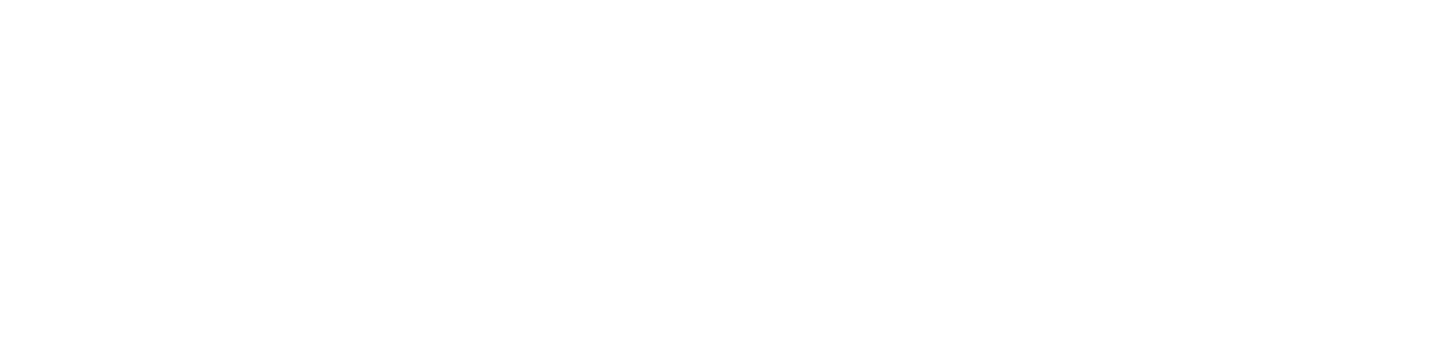

In [31]:
%matplotlib notebook
fig = sns.catplot(data = data_AGB_prod_NomProdSimple, x = 'Nom produit simple', y = 'PEF', kind = 'bar', aspect = 4)
fig.set_xticklabels(rotation=90);


In [32]:
data_tmp = data_AGB_prod_NomProdSimple.groupby('Nom produit simple')['PEF']\
                            .agg(['mean', 'std', 'count'])\
                            .sort_values(by = 'std', ascending = False)

data_tmp.head(10)

,mean,std,count
Nom produit simple,,,
Pêche,2.280020,2.923469,2
Café,2.208750,2.125908,5
Coeur,1.405064,1.268880,10
Cervelle,1.772000,1.231794,6
Foie,1.107736,1.172339,16
Rognon,1.963311,1.121839,8
Chicorée et café,0.891758,1.028990,3
Langue,1.891342,1.009299,5
Lait 1er âge,0.840372,0.978811,2


As seen before, for some products, it is not fully meaningful to simplify the product name "A1, A2, A3, ..." by its first noun "A1" before the first comma and take the score mean **since there might exist big variations between entries with same A1 but different A2, A3, ... However, we will follow this approach for simplicity reasons.** The best approach would be probably to identify the problematic ingredients and:
- either store the corresponding error bars 
- or keep the full name A1, A2, A3 (but probably there is no hope to reach this precision level with restaurant menus)

#### Let's continue with the sheet "Détail ingredient"  
**NOTE: THIS PART IS FULLY USELESS AND CAN BE IGNORED SINCE I REALIZED LATER THAT ALL RECIPES CONTAINED IN THIS SHEET ARE ACTUALLY ALREADY PRESENT IN THE SHEET "Synthese"!**

In [33]:
data_AGB_recipe = pd.read_excel("../data/Agribalyse/AGRIBALYSE3.1_produits alimentaires_2.xlsm", \
                                     sheet_name = 'Detail ingredient', skiprows = 2, header = [0, 1])

In [34]:
data_AGB_recipe.head()

,Unnamed: 0_level_0,Unnamed: 1_level_0,Unnamed: 2_level_0,Unnamed: 3_level_0,Unnamed: 4_level_0,Unnamed: 5_level_0,Unnamed: 6_level_0,Unnamed: 7_level_0,Unnamed: 8_level_0,Unnamed: 9_level_0,...,Effets toxicologiques sur la santé humaine : substances cancérogènes,Acidification terrestre et eaux douces,Eutrophisation eaux douces,Eutrophisation marine,Eutrophisation terrestre,Écotoxicité pour écosystèmes aquatiques d'eau douce,Utilisation du sol,Épuisement des ressources eau,Épuisement des ressources énergétiques,Épuisement des ressources minéraux
,Ciqual \nAGB,Ciqual \ncode,Groupe d'aliment,Sous-groupe d'aliment,Nom Français,LCI Name,Ingredients,Code et Nom,Groupe,Sous-groupe,...,CTUh/kg de produit,mol H+ eq/kg de produit,kg P eq/kg de produit,kg N eq/kg de produit,mol N eq/kg de produit,CTUe/kg de produit,Pt/kg de produit,m3 depriv./kg de produit,MJ/kg de produit,kg Sb eq/kg de produit
0,37000,37000,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza à la crème,cream sauce for pizza base,Fromage frais crémeux,Base de pizza à la crème (37000),aides culinaires et ingrédients divers,ingrédients divers,...,1.238657e-09,0.017189,0.000222,0.005425,0.072309,17.540426,90.117834,0.310087,8.091825,1.475048e-05
1,37000,37000,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza à la crème,cream sauce for pizza base,Autres étapes,Base de pizza à la crème (37000),aides culinaires et ingrédients divers,ingrédients divers,...,2.342482e-10,0.002161,0.000090,0.001300,0.006976,2.311035,9.058034,0.144493,15.269280,2.320229e-06
2,37000,37000,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza à la crème,cream sauce for pizza base,Total,Base de pizza à la crème (37000),aides culinaires et ingrédients divers,ingrédients divers,...,1.472905e-09,0.019350,0.000312,0.006725,0.079285,19.851461,99.175868,0.454580,23.361105,1.707071e-05
3,37002,37002,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza tomatée,Tomato sauce for pizza base,Huile d'olive,Base de pizza tomatée (37002),aides culinaires et ingrédients divers,ingrédients divers,...,4.180170e-10,0.003773,0.000052,0.001739,0.015762,5.577347,54.288788,1.945284,1.720683,1.893375e-06
4,37002,37002,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza tomatée,Tomato sauce for pizza base,Oignons,Base de pizza tomatée (37002),aides culinaires et ingrédients divers,ingrédients divers,...,1.367361e-11,0.000111,0.000003,0.000125,0.000408,0.230512,0.998462,0.165128,0.137714,1.518909e-07


Rename the columns

In [35]:
# Flatten the MultiIndex into a Single Index
data_AGB_recipe.columns = ['_'.join(col) if type(col) is tuple else col for col in data_AGB_recipe.columns.values]
data_AGB_recipe.head(2)

,Unnamed: 0_level_0_Ciqual \nAGB,Unnamed: 1_level_0_Ciqual \ncode,Unnamed: 2_level_0_Groupe d'aliment,Unnamed: 3_level_0_Sous-groupe d'aliment,Unnamed: 4_level_0_Nom Français,Unnamed: 5_level_0_LCI Name,Unnamed: 6_level_0_Ingredients,Unnamed: 7_level_0_Code et Nom,Unnamed: 8_level_0_Groupe,Unnamed: 9_level_0_Sous-groupe,...,Effets toxicologiques sur la santé humaine : substances cancérogènes_CTUh/kg de produit,Acidification terrestre et eaux douces_mol H+ eq/kg de produit,Eutrophisation eaux douces_kg P eq/kg de produit,Eutrophisation marine_kg N eq/kg de produit,Eutrophisation terrestre_mol N eq/kg de produit,Écotoxicité pour écosystèmes aquatiques d'eau douce_CTUe/kg de produit,Utilisation du sol_Pt/kg de produit,Épuisement des ressources eau_m3 depriv./kg de produit,Épuisement des ressources énergétiques_MJ/kg de produit,Épuisement des ressources minéraux_kg Sb eq/kg de produit
0,37000,37000,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza à la crème,cream sauce for pizza base,Fromage frais crémeux,Base de pizza à la crème (37000),aides culinaires et ingrédients divers,ingrédients divers,...,1.238657e-09,0.017189,0.000222,0.005425,0.072309,17.540426,90.117834,0.310087,8.091825,0.000015
1,37000,37000,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza à la crème,cream sauce for pizza base,Autres étapes,Base de pizza à la crème (37000),aides culinaires et ingrédients divers,ingrédients divers,...,2.342482e-10,0.002161,0.000090,0.001300,0.006976,2.311035,9.058034,0.144493,15.269280,0.000002


In [36]:
data_AGB_recipe.columns

Index(['Unnamed: 0_level_0_Ciqual \nAGB', 'Unnamed: 1_level_0_Ciqual \ncode',
       'Unnamed: 2_level_0_Groupe d'aliment',
       'Unnamed: 3_level_0_Sous-groupe d'aliment',
       'Unnamed: 4_level_0_Nom Français', 'Unnamed: 5_level_0_LCI Name',
       'Unnamed: 6_level_0_Ingredients', 'Unnamed: 7_level_0_Code et Nom',
       'Unnamed: 8_level_0_Groupe', 'Unnamed: 9_level_0_Sous-groupe',
       'Score unique EF 3.1_mPt/kg de produit',
       'Changement climatique_kg CO2 eq/kg de produit',
       'Appauvrissement de la couche d'ozone_kg CVC11 eq/kg de produit',
       'Rayonnements ionisants_kBq U-235 eq/kg de produit',
       'Formation photochimique d'ozone_kg NMVOC eq/kg de produit',
       'Particules fines_disease inc./kg de produit',
       'Effets toxicologiques sur la santé humaine : substances non-cancérogènes_CTUh/kg de produit',
       'Effets toxicologiques sur la santé humaine : substances cancérogènes_CTUh/kg de produit',
       'Acidification terrestre et eaux douces_m

Are the columns "Groupe d'aliment"/"Groupe" and "Sous-groupe d'aliment"/"Sous-groupe" identical?

In [37]:
print(data_AGB_recipe["Unnamed: 2_level_0_Groupe d'aliment"].equals(data_AGB_recipe["Unnamed: 8_level_0_Groupe"]))
print(data_AGB_recipe["Unnamed: 3_level_0_Sous-groupe d'aliment"].equals(data_AGB_recipe["Unnamed: 9_level_0_Sous-groupe"]))

False
False


In [38]:
arr1 = np.where(data_AGB_recipe["Unnamed: 2_level_0_Groupe d'aliment"]!=data_AGB_recipe["Unnamed: 8_level_0_Groupe"])[0]
arr2 = np.where(data_AGB_recipe["Unnamed: 3_level_0_Sous-groupe d'aliment"]!=data_AGB_recipe["Unnamed: 9_level_0_Sous-groupe"])[0]
list_diff = arr1.tolist() + arr2.tolist()
print(list_diff)

[660, 1178, 3507, 6136, 660, 1178, 3507, 6136]


In [39]:
data_AGB_recipe.loc[list_diff, ["Unnamed: 4_level_0_Nom Français", "Unnamed: 2_level_0_Groupe d'aliment", \
                                "Unnamed: 3_level_0_Sous-groupe d'aliment", \
                                'Unnamed: 6_level_0_Ingredients', \
                                "Unnamed: 8_level_0_Groupe", \
                                "Unnamed: 9_level_0_Sous-groupe"]]

,Unnamed: 4_level_0_Nom Français,Unnamed: 2_level_0_Groupe d'aliment,Unnamed: 3_level_0_Sous-groupe d'aliment,Unnamed: 6_level_0_Ingredients,Unnamed: 8_level_0_Groupe,Unnamed: 9_level_0_Sous-groupe
660,"Boisson au thé, aromatisée, sucrée",boissons,boissons sans alcool,Viande,"viandes, œufs, poissons",charcuteries
1178,Coq au vin,entrées et plats composés,plats composés,Viande,"viandes, œufs, poissons",charcuteries
3507,Pêche melba,glaces et sorbets,desserts glacés,Cacahuète,"fruits, légumes, légumineuses et oléagineux",fruits à coque et graines oléagineuses
6136,Calissons d'Aix en Provence,produits sucrés,confiseries non chocolatées,Viande,"viandes, œufs, poissons",charcuteries
660,"Boisson au thé, aromatisée, sucrée",boissons,boissons sans alcool,Viande,"viandes, œufs, poissons",charcuteries
1178,Coq au vin,entrées et plats composés,plats composés,Viande,"viandes, œufs, poissons",charcuteries
3507,Pêche melba,glaces et sorbets,desserts glacés,Cacahuète,"fruits, légumes, légumineuses et oléagineux",fruits à coque et graines oléagineuses
6136,Calissons d'Aix en Provence,produits sucrés,confiseries non chocolatées,Viande,"viandes, œufs, poissons",charcuteries


There is meat in "calissons" and "boisson au thé"! Super weird!   
This situation concerns only the ingredients details. **In the following, we will only consider the entries where Ingredients=Total (ie the full recipe) and hence we can safely remove the columns "Groupe" and "Sous-groupe".**

In [40]:
data_AGB_recipe = data_AGB_recipe[data_AGB_recipe['Unnamed: 6_level_0_Ingredients']=='Total']
data_AGB_recipe.head(2)

,Unnamed: 0_level_0_Ciqual \nAGB,Unnamed: 1_level_0_Ciqual \ncode,Unnamed: 2_level_0_Groupe d'aliment,Unnamed: 3_level_0_Sous-groupe d'aliment,Unnamed: 4_level_0_Nom Français,Unnamed: 5_level_0_LCI Name,Unnamed: 6_level_0_Ingredients,Unnamed: 7_level_0_Code et Nom,Unnamed: 8_level_0_Groupe,Unnamed: 9_level_0_Sous-groupe,...,Effets toxicologiques sur la santé humaine : substances cancérogènes_CTUh/kg de produit,Acidification terrestre et eaux douces_mol H+ eq/kg de produit,Eutrophisation eaux douces_kg P eq/kg de produit,Eutrophisation marine_kg N eq/kg de produit,Eutrophisation terrestre_mol N eq/kg de produit,Écotoxicité pour écosystèmes aquatiques d'eau douce_CTUe/kg de produit,Utilisation du sol_Pt/kg de produit,Épuisement des ressources eau_m3 depriv./kg de produit,Épuisement des ressources énergétiques_MJ/kg de produit,Épuisement des ressources minéraux_kg Sb eq/kg de produit
2,37000,37000,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza à la crème,cream sauce for pizza base,Total,Base de pizza à la crème (37000),aides culinaires et ingrédients divers,ingrédients divers,...,1.472905e-09,0.019350,0.000312,0.006725,0.079285,19.851461,99.175868,0.454580,23.361105,0.000017
7,37002,37002,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza tomatée,Tomato sauce for pizza base,Total,Base de pizza tomatée (37002),aides culinaires et ingrédients divers,ingrédients divers,...,1.023373e-09,0.007996,0.000179,0.004171,0.030201,10.060278,61.123694,3.860367,21.375069,0.000007


In [41]:
col_to_drop = ['Unnamed: 6_level_0_Ingredients', 'Unnamed: 7_level_0_Code et Nom', \
               "Unnamed: 8_level_0_Groupe", "Unnamed: 9_level_0_Sous-groupe"]
data_AGB_recipe = data_AGB_recipe.drop(col_to_drop, axis=1)
data_AGB_recipe.head(2)

,Unnamed: 0_level_0_Ciqual \nAGB,Unnamed: 1_level_0_Ciqual \ncode,Unnamed: 2_level_0_Groupe d'aliment,Unnamed: 3_level_0_Sous-groupe d'aliment,Unnamed: 4_level_0_Nom Français,Unnamed: 5_level_0_LCI Name,Score unique EF 3.1_mPt/kg de produit,Changement climatique_kg CO2 eq/kg de produit,Appauvrissement de la couche d'ozone_kg CVC11 eq/kg de produit,Rayonnements ionisants_kBq U-235 eq/kg de produit,...,Effets toxicologiques sur la santé humaine : substances cancérogènes_CTUh/kg de produit,Acidification terrestre et eaux douces_mol H+ eq/kg de produit,Eutrophisation eaux douces_kg P eq/kg de produit,Eutrophisation marine_kg N eq/kg de produit,Eutrophisation terrestre_mol N eq/kg de produit,Écotoxicité pour écosystèmes aquatiques d'eau douce_CTUe/kg de produit,Utilisation du sol_Pt/kg de produit,Épuisement des ressources eau_m3 depriv./kg de produit,Épuisement des ressources énergétiques_MJ/kg de produit,Épuisement des ressources minéraux_kg Sb eq/kg de produit
2,37000,37000,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza à la crème,cream sauce for pizza base,0.222564,1.980182,1.052756e-07,0.729692,...,1.472905e-09,0.019350,0.000312,0.006725,0.079285,19.851461,99.175868,0.454580,23.361105,0.000017
7,37002,37002,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza tomatée,Tomato sauce for pizza base,0.146629,0.721281,1.125203e-07,0.570411,...,1.023373e-09,0.007996,0.000179,0.004171,0.030201,10.060278,61.123694,3.860367,21.375069,0.000007


In [42]:
data_AGB_recipe['Unnamed: 0_level_0_Ciqual \nAGB'].equals(data_AGB_recipe['Unnamed: 1_level_0_Ciqual \ncode'])

True

Though the two columns are identical, we keep them both because later, we will merge this dataframe with the other agribalyse dataframes where the two codes are sometimes different.

In [43]:
old_col_names = data_AGB_recipe.columns

new_col_names = ['Code AGB',
                 'Code CIQUAL',
                 'Groupe',
                 'Sous-groupe',
                 'Nom produit',    # Nom du Produit en Français (traduction approximative GoogleTranslate)
                 'LCI name', 
                 'PEF',            # Score unique EF3.1 (mPt/kg)
                 'CO2',            # Changement climatique (kg CO2 eq/kg)
                 'Ozone_1',        # Appauvrissement de la couche d'ozone (kg CFC11 eq/kg)
                 'Rad',            # Rayonnements ionisants (kBq U-235 eq/kg)
                 'Ozone_2',        # Formation photochimique d'ozone (kg NMVOC eq/kg)
                 'Particules',     # Particules (disease inc./kg)
                 'Toxic_1',        # Effets toxicologiques sur la santé humaine : substances non-cancérogènes (CTUh/kg)
                 'Toxic_2',        # Effets toxicologiques sur la santé humaine : substances cancérogènes (CTUh/kg)
                 'Acid',           # Acidification terrestre et eaux douces (mol H+ eq/kg)
                 'Eutro_1',        # Eutrophisation eaux douces (kg P eq/kg)
                 'Eutro_2',        # Eutrophisation marine (kg N eq/kg)
                 'Eutro_2',        # Eutrophisation terrestre (mol N eq/kg)
                 'Ecotoxic',       # Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg)
                 'Sol',            # Utilisation du sol (Pt/kg)
                 'Ressource_1',    # Épuisement des ressources eau (m3 depriv./kg)
                 'Ressource_2',    # Épuisement des ressources énergétiques (MJ/kg)
                 'Ressource_3'     # Épuisement des ressources minéraux (kg Sb eq/kg)
                ]


dict_col_rename = {}
for i in range(len(old_col_names)):
    dict_col_rename[old_col_names[i]] = new_col_names[i]
    
data_AGB_recipe = data_AGB_recipe.rename(columns = dict_col_rename)

In [44]:
data_AGB_recipe.head(2)

,Code AGB,Code CIQUAL,Groupe,Sous-groupe,Nom produit,LCI name,PEF,CO2,Ozone_1,Rad,...,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
2,37000,37000,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza à la crème,cream sauce for pizza base,0.222564,1.980182,1.052756e-07,0.729692,...,1.472905e-09,0.019350,0.000312,0.006725,0.079285,19.851461,99.175868,0.454580,23.361105,0.000017
7,37002,37002,aides culinaires et ingrédients divers,ingrédients divers,Base de pizza tomatée,Tomato sauce for pizza base,0.146629,0.721281,1.125203e-07,0.570411,...,1.023373e-09,0.007996,0.000179,0.004171,0.030201,10.060278,61.123694,3.860367,21.375069,0.000007


In [45]:
data_AGB_recipe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063 entries, 2 to 6855
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Code AGB     1063 non-null   object 
 1   Code CIQUAL  1063 non-null   object 
 2   Groupe       1063 non-null   object 
 3   Sous-groupe  1063 non-null   object 
 4   Nom produit  1063 non-null   object 
 5   LCI name     1063 non-null   object 
 6   PEF          1063 non-null   float64
 7   CO2          1063 non-null   float64
 8   Ozone_1      1063 non-null   float64
 9   Rad          1063 non-null   float64
 10  Ozone_2      1063 non-null   float64
 11  Particules   1063 non-null   float64
 12  Toxic_1      1063 non-null   float64
 13  Toxic_2      1063 non-null   float64
 14  Acid         1063 non-null   float64
 15  Eutro_1      1063 non-null   float64
 16  Eutro_2      1063 non-null   float64
 17  Eutro_2      1063 non-null   float64
 18  Ecotoxic     1063 non-null   float64
 19  Sol   

In [46]:
data_AGB_recipe.isna().sum().sum()

0

There are 1063 recipes and no missing values. 

In [47]:
plt.title("PEF score histogram for the dataset AGRIBALYSE3.1_produits alimentaires_2.xlsm, sheet 'Detail ingredient'")
plt.xlabel("PEF (mPt/kg)")
sns.histplot(data_AGB_recipe['PEF']);

What are the best and worse recipes in terms of PEF?

In [48]:
data_AGB_recipe.sort_values(by=['PEF'])[['Nom produit', 'PEF']]

,Nom produit,PEF
980,Bouillon de volaille,0.014675
967,"Bouillon de boeuf, déshydraté reconstitué",0.015140
974,"Bouillon de légumes, déshydraté reconstitué",0.015409
2646,"Soupe à la volaille et aux légumes, déshydraté...",0.018123
2652,"Soupe à la volaille et aux légumes, préemballé...",0.018123
...,...,...
6367,"Merguez, boeuf et mouton, crue",4.165714
6374,"Merguez, boeuf et mouton, cuite",4.197308
6381,"Merguez, bœuf, mouton et porc, crue",7.263685
6387,"Merguez, crue",9.211933


In [49]:
pd.Series(data_AGB_recipe['Nom produit'].isin(data_AGB_prod['Nom produit'])).apply(int).sum()

1063

Damn! All the ingredients contained in data_AGB_recipe are already in data_AGB_prod. I didn't notice it before. So this part is completely useless.

### Let's now merge the two agribalyse dataframes (or not?)

In [50]:
data_AGB_prod.head(2)

,Code AGB,Code CIQUAL,Groupe,Sous-groupe,Nom produit,LCI name,Code saison,Code avion,Livraison,Emballage,...,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,11084,11084,aides culinaires et ingrédients divers,algues,"Agar (algue), cru","Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.01328,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088
1,11023,11023,aides culinaires et ingrédients divers,herbes,"Ail séché, poudre","Garlic, powder, dried",2,0,Ambiant (long),Verre,...,4.662163e-10,0.006222,0.000124,0.00232,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007


In [51]:
data_AGB_farm.head(2)

,Nom produit,LCI name,Catégorie,PEF,CO2,Ozone_1,Rad,Ozone_2,Particules,Toxic_1,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,"Agneau système de production conventionnel, in...","Lamb, conventional, indoor production system, ...",Agricultural\Animal production\Ovine\Transform...,1.861962,16.260055,3.812082e-07,0.384010,0.025777,1.971493e-06,3.151420e-07,8.673159e-09,0.291614,0.001083,0.063427,1.291483,75.263604,1772.33090,5.034850,36.407330,0.000024
1,"Agneau, conventionnel, système Roquefort, à la...","Lamb, conventional, Roquefort system, at farm ...",Agricultural\Animal production\Ovine\Transform...,0.584921,4.343651,1.087468e-07,0.226843,0.005949,7.182928e-07,5.785546e-08,1.952941e-09,0.104941,0.000236,0.021571,0.465543,15.864931,507.66491,0.690593,12.829857,0.000006


In the column 'Nom produit', simplify the ingredient name of type 'A1, A2, A3, ...' to 'A1'.

In [52]:
data_AGB_prod_Simple = data_AGB_prod.copy()
data_AGB_prod_Simple['Nom produit'] = data_AGB_prod_Simple['Nom produit'].apply(lambda x: x.split(',')[0])
data_AGB_prod_Simple = data_AGB_prod_Simple.rename({'Nom produit': 'Nom produit simple'}, axis = 1)

data_AGB_farm_Simple = data_AGB_farm.copy()
data_AGB_farm_Simple['Nom produit'] = data_AGB_farm_Simple['Nom produit'].apply(lambda x: x.split(',')[0])
data_AGB_farm_Simple = data_AGB_farm_Simple.rename({'Nom produit': 'Nom produit simple'}, axis = 1)

In [53]:
data_AGB_farm_Simple

,Nom produit simple,LCI name,Catégorie,PEF,CO2,Ozone_1,Rad,Ozone_2,Particules,Toxic_1,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,Agneau système de production conventionnel,"Lamb, conventional, indoor production system, ...",Agricultural\Animal production\Ovine\Transform...,1.861962,16.260055,3.812082e-07,0.384010,0.025777,1.971493e-06,3.151420e-07,8.673159e-09,0.291614,0.001083,0.063427,1.291483,75.263604,1772.330900,5.034850,36.407330,2.358424e-05
1,Agneau,"Lamb, conventional, Roquefort system, at farm ...",Agricultural\Animal production\Ovine\Transform...,0.584921,4.343651,1.087468e-07,0.226843,0.005949,7.182928e-07,5.785546e-08,1.952941e-09,0.104941,0.000236,0.021571,0.465543,15.864931,507.664910,0.690593,12.829857,6.261006e-06
2,Algue production non optimisée,"Seaweed non-optimized production, 1kg algae (L...",Agricultural\Plant production\Other\Transforma...,0.124275,0.847301,1.506487e-07,0.170081,0.005215,1.169689e-07,1.062670e-08,9.602334e-10,0.016369,0.000269,0.001661,0.016217,7.714319,2.935613,0.498027,15.473219,1.410668e-05
3,Algue production optimisée,"Optimized seaweed production, 1kg algae (Lamin...",Agricultural\Plant production\Other\Transforma...,0.011687,0.101435,8.726019e-09,0.024856,0.000704,8.763355e-09,5.707872e-10,1.322074e-10,0.001000,0.000021,0.000253,0.002433,0.286383,0.287014,0.057395,2.098933,4.606886e-07
4,Ananas,"Pineapple, mixed production, Reunion Island av...",Agricultural\Plant production\Fruits\Transform...,0.094164,0.867768,3.080570e-08,0.020339,0.002294,1.149442e-07,1.796827e-09,9.500784e-11,0.010308,0.000022,0.006681,0.069733,2.686393,25.756989,0.544602,2.904503,1.260082e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,Vache de réforme,"Cull cow, conventional, highland milk system, ...",Agricultural\Animal production\Bovine\Transfor...,1.257408,13.582066,3.037772e-07,0.228053,0.019482,1.207820e-06,1.988068e-07,5.848074e-09,0.180317,0.000654,0.029072,0.795459,31.084926,1195.508300,2.721152,30.051625,2.234046e-05
255,Vache de réforme,"Cull cow, conventional, lowland milk system, s...",Agricultural\Animal production\Bovine\Transfor...,1.045143,10.687261,2.307972e-07,0.207631,0.016189,1.032643e-06,2.052253e-07,5.057575e-09,0.153839,0.000642,0.035704,0.679355,59.512419,598.595380,3.305013,20.627510,2.161145e-05
256,Vache de réforme,"Cull cow, conventional, lowland milk system, s...",Agricultural\Animal production\Bovine\Transfor...,1.231018,11.822850,1.952611e-07,0.186806,0.017739,1.360781e-06,2.568049e-07,5.066379e-09,0.202560,0.000454,0.040713,0.899541,26.728785,782.201160,2.074972,16.945672,2.003416e-05
257,Vache de réforme,"Cull cow, conventional, lowland milk system, s...",Agricultural\Animal production\Bovine\Transfor...,0.814341,8.683875,1.946210e-07,0.165955,0.013593,7.500397e-07,1.553941e-07,4.169357e-09,0.112694,0.000537,0.030275,0.496678,46.435263,528.541190,2.368120,17.115147,1.857216e-05


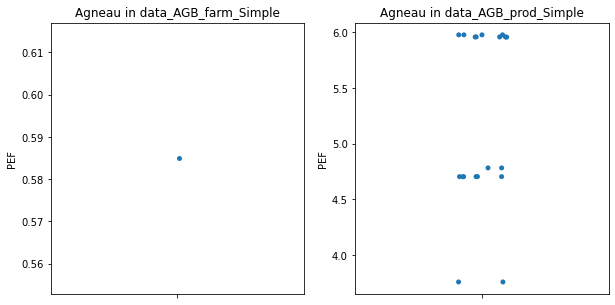

In [54]:
%matplotlib inline

which = 'Agneau'

fig, axs = plt.subplots(ncols=2, figsize = (10, 5))
axs[0].set_title(which + ' in data_AGB_farm_Simple')
sns.stripplot(data = data_AGB_farm_Simple[data_AGB_farm_Simple['Nom produit simple']==which], y = 'PEF', ax = axs[0])
axs[1].set_title(which + ' in data_AGB_prod_Simple')
sns.stripplot(data = data_AGB_prod_Simple[data_AGB_prod_Simple['Nom produit simple']==which], y = 'PEF', ax = axs[1]);

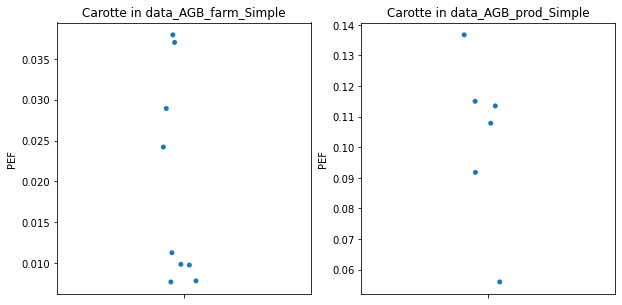

In [55]:
which = 'Carotte'

fig, axs = plt.subplots(ncols=2, figsize = (10, 5))
axs[0].set_title(which + ' in data_AGB_farm_Simple')
sns.stripplot(data = data_AGB_farm_Simple[data_AGB_farm_Simple['Nom produit simple']==which], y = 'PEF', ax = axs[0])
axs[1].set_title(which + ' in data_AGB_prod_Simple')
sns.stripplot(data = data_AGB_prod_Simple[data_AGB_prod_Simple['Nom produit simple']==which], y = 'PEF', ax = axs[1]);

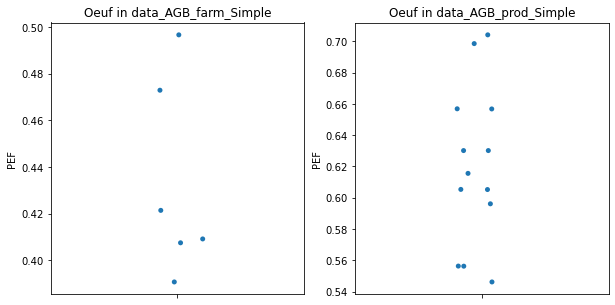

In [56]:
which = 'Oeuf'

fig, axs = plt.subplots(ncols=2, figsize = (10, 5))
axs[0].set_title(which + ' in data_AGB_farm_Simple')
sns.stripplot(data = data_AGB_farm_Simple[data_AGB_farm_Simple['Nom produit simple']==which], y = 'PEF', ax = axs[0])
axs[1].set_title(which + ' in data_AGB_prod_Simple')
sns.stripplot(data = data_AGB_prod_Simple[data_AGB_prod_Simple['Nom produit simple']==which], y = 'PEF', ax = axs[1]);

Conclusion: as expected, the PEF distribution of ingredients in the 2 dataframes are very different (the PEF of ingredients coming from the farm are much smaller than the one of "commercial" ingredients) -> therefore, for the moment, we will not consider the data coming from the farm (ie "../data/Agribalyse/AGRIBALYSE3.1_partie agriculture_conv_vf.xlsx").  
- The idea is rather to correct subsequently the PEF of "commercial" ingredients with bonus/malus and calculate the ECOSCORE. If we take the average of PEFs for a given ingredient coming from the two databases, we will somehow include twice the origin/packaging/etc... effect.
- On the contrary, if we don't want to calculate the ECOSCORE but only the PEF, it makes sense to include data from the farm (with a simple average or more precise calculations depending on infos we get from the menus).

### Let's prepare now the dataframe for JOW ingredients

In [272]:
jow_data = pd.read_json('../data/Recipes/recipes_jow.json')
jow_data.head()

,Yakitori bœuf fromage,Gnocchis Epinards Gorgonzola,Dahl de lentilles corail,Veggie lasagna,Pasta alla carbonara,Tarte spirale de légumes,Flammeküeche,Chili con carne,Les classiques coquillettes au jambon,Knack & purée,...,Ratatouille,"Poêlée de courgettes, feta & œuf",Rillettes de sardines pimentées,Labneh maison,Nectarine rôtie & glace vanille,Taco shells au bœuf,Crousti'Taco,Granité à la grenadine,Granité à la pêche,Granité à la menthe
cuisson,10 minutes,5 minutes,plat froid,50 minutes,9 minutes,45 minutes,12 minutes,plat froid,7 minutes,plat froid,...,30 minutes,10 minutes,plat froid,12 heures,4 minutes,12 minutes,17 minutes,3 heures,3 heures,3 heures
ingredients,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]","[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]","[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]","[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]","[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]","[[1, Pâte brisée], [2, Courgette], [4, Carotte (frais)], [20 cl, Crème liquide], [1, Œuf], [2 càs, Moutarde à l'ancienne]]","[[1, Pâte à pizza], [3 càs, Fromage blanc], [3 càs, Crème fraîche épaisse], [100 g, Lardons], [1, Oignon jaune]]","[[100 g, Bœuf (haché)], [100 g, Tomate (chair)], [Facultatif, 1 pinc., Origan (séché)], [100 g, Haricots rouges (cuits)], [1/2 càc], [1/4], [1 càc], [70 g]]","[[100 g, Pâtes (coquillettes)], [1 tran., Jambon blanc]]","[[250 g, Pomme de terre], [2, Knack (porc)], [5 cl, Lait], [20 g, Beurre]]",...,"[[80 g, Poivron rouge], [80 g, Courgette], [80 g, Aubergine], [125 g, Tomate (à cuire)], [1/2, Oignon jaune], [1/2, Ail], [1/10, Bouquet garni]]","[[1, Courgette], [2, Œuf], [40 g, Feta], [1 pinc., Origan (séché)], [Facultatif, 1/10 bou., Ciboulette]]","[[20 g, Sardine au piment], [20 g, Fromage frais]]","[[100 g, Yaourt Grec], [1/2 càs, Huile d'olive]]","[[1 boule, Crème glacée Vanille], [1, Nectarine], [15 g, Amandes (effilées)], [20 g, Beurre], [1 càc, Sucre de canne]]","[[3, Taco kit], [100 g, Bœuf (haché)], [1/4, Oignon rouge], [1 càs, Crème fraîche épaisse], [10 g, Cheddar (râpé)], [1/4, Citron vert], [1 poignée, Salade (coeur de laitue)]]","[[2, Crousti' taco kit], [100 g, Bœuf (haché)], [1/4, Oignon jaune], [1/2, Avocat], [1 poignée, Salade (coeur de laitue)], [1, Tomate], [15 g, Fromage râpé]]","[[2 cl, Grenadine]]","[[2 cl, Sirop de pêche]]","[[2 cl, Sirop de menthe]]"


In [273]:
jow_data = jow_data.transpose()
pd.set_option('display.max_colwidth', None)
jow_data.head(10)


,cuisson,ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]"
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]"
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]"
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]"
Tarte spirale de légumes,45 minutes,"[[1, Pâte brisée], [2, Courgette], [4, Carotte (frais)], [20 cl, Crème liquide], [1, Œuf], [2 càs, Moutarde à l'ancienne]]"
Flammeküeche,12 minutes,"[[1, Pâte à pizza], [3 càs, Fromage blanc], [3 càs, Crème fraîche épaisse], [100 g, Lardons], [1, Oignon jaune]]"
Chili con carne,plat froid,"[[100 g, Bœuf (haché)], [100 g, Tomate (chair)], [Facultatif, 1 pinc., Origan (séché)], [100 g, Haricots rouges (cuits)], [1/2 càc], [1/4], [1 càc], [70 g]]"
Les classiques coquillettes au jambon,7 minutes,"[[100 g, Pâtes (coquillettes)], [1 tran., Jambon blanc]]"
Knack & purée,plat froid,"[[250 g, Pomme de terre], [2, Knack (porc)], [5 cl, Lait], [20 g, Beurre]]"


We extract the list of ingredients and remove informations in parenthesis + convert ligatures

In [59]:
# Does not work
import ftfy
print(ftfy.fixes.fix_latin_ligatures("Bœuf"))

print(ftfy.fixes.fix_latin_ligatures("ﬂuﬃeﬆ"))


Bœuf
fluffiest


In [274]:
import re

REGEX_REPLACEMENTS = [
    (r"\u0153", "oe"),
    (r"\u0152", "Oe"),
]

transcript = """
Bœuf (carpaccio)
"""

def remove_ligatures(transcript):
    for old, new in REGEX_REPLACEMENTS:
        transcript = re.sub(old, new, transcript, flags=re.IGNORECASE)
    return transcript

print(remove_ligatures(transcript))


Boeuf (carpaccio)



In [275]:
jow_data['ingredients'] = jow_data['ingredients'].apply(lambda x: [[remove_ligatures(str(s)) for s in l] for l in x ])
jow_data.head()

,cuisson,ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Boeuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]"
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]"
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]"
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, oeuf], [40 g, Parmesan (morceaux)]]"


In [277]:
'''
import json 

with open('../data/Recipes/recipes_jow.json') as json_file:
    jow_dict = json.load(json_file)
'''
    
jow_dict = jow_data.to_dict('index')

    
# Keeping only ingredients
all_ingredients = []

for key in jow_dict:
    for i in jow_dict[key]["ingredients"]:
        '''
        try:
            # Keep only the ingredients, remove the quantity
            if len(i)==2:
                all_ingredients.append(i[1])
            elif len(i)==3:
                all_ingredients.append(i[2])
        except:
            pass
        '''
        if len(i)>1:
            all_ingredients.append(i[-1])
        else:
            print(i)
        
print(len(all_ingredients))


all_ingredients = list(dict.fromkeys(all_ingredients))   # to remove doublons I guess
print(len(all_ingredients))

print(all_ingredients[:20])

all_ingredients = [re.sub("[\(\[].*?[\)\]]", "", x) for x in all_ingredients]  #remove informations in parenthesis
all_ingredients = list(dict.fromkeys(all_ingredients))
print(len(all_ingredients))

print(all_ingredients[:20])

['1/2 càc']
['1/4']
['1 càc']
['70 g']
['20 g']
['1']
['1/4 gou.']
['1/4']
['1']
['1/4 càc']
['80 g']
['30 g']
['2 tran.']
['3/10 bou.']
['1/2 gou.']
['1/5 bou.']
['2 càs']
['Facultatif']
['1 poignée']
['1 càc']
['400 g']
['400 g']
['1 càc']
['1/4']
['60 g']
['70 g']
['1 càs']
['2 càs']
['1/4 gou.']
['Facultatif']
['1 càc']
['1/4 sac.']
['20 g']
['2 tran.']
['1 càc']
['Facultatif']
['Facultatif']
['1 càc']
['1/4']
['50 g']
['Facultatif']
['1/2 càs']
['1/4']
['2 cl']
['1 càs']
['2 càc']
['100 g']
['1']
['10 cl']
['100 g']
['10 cl']
['3']
['Facultatif']
['2 tran.']
['1 càc']
['1 g']
['1/4 gou.']
['1 càc']
['1/4 gou.']
['1/4']
['1/10 bou.']
['1/4']
['10 g']
['1/2']
['Facultatif']
['50 g']
['1/4 gou.']
['1/4 gou.']
['1/10 bou.']
['1 càc']
['1/2']
['1/4 gou.']
['50 g']
['1/4']
['1/2']
['225 g']
['1']
['3/5 bou.']
['Facultatif']
['120 g']
['1 sac.']
['80 g']
['1/4']
['Facultatif']
['Facultatif']
['20 g']
['1 càc']
['Facultatif']
['1/4']
['1/4']
['1/2 pinc.']
['200 g']
['1 sac.']
['4 càs']
['

There are 498 JOW ingredients after simplification.

In [341]:
df_ingredients = pd.DataFrame(all_ingredients, columns=["JOW ingredients (fr)"])
df_ingredients.head()

,JOW ingredients (fr)
0,Boeuf
1,Emmental
2,Sauce Teriyaki
3,Riz
4,Pics à brochette


In [342]:
def remove_blank(transcript):
    if transcript[-1] == " ":
        return transcript[:-1]
    else: 
        return transcript

# When parenthesis have been removed, a blank space has remained
df_ingredients['JOW ingredients (fr)'] = df_ingredients['JOW ingredients (fr)'].apply(remove_blank)  

### Match the two bdds ie df_ingredients (JOW) and data_AGB_prod_Simple (Agribalyse)

In [343]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
#import nltk
#from nltk.stem.snowball import FrenchStemmer
#stemmer = FrenchStemmer()

# Very simple and bad function to singularize
# Only works when the plural comes with a "s" e.g. "champignons", not with a "x"
# I tried to find best solutions with re or nltk but with no success
# Should be improved
def singularize(word):
    if word[-1]=='s':
        return word[:-1]
    else:
        return word

# Most important function written quickly -> should be improved!
def most_similar_ingredient(string, list_ingredients, tresh):
    
    list_ingredients = list(set(list_ingredients))
    s = string.lower()
    
    scores = [fuzz.token_sort_ratio(s, ingredient) for ingredient in list_ingredients]
    # Note that the case where several ingredients have the same score is not included
    idx_score, score = max(list(enumerate(scores)), key=lambda x: x[1])  # max of scores with its index idx_score
    
    if score > tresh:
        res =  list_ingredients[idx_score] 
        
    else: 
        # Match if the first word of jow and of agribalyse are equal (up to a final "s")
        res_3 = []
        s0 = s.split(" ")[0]    # first word of s

        for ingredient in list_ingredients:
            ingredient0 = ingredient.lower().split(" ")[0]   # first word of ingredient
            if singularize(s0)==singularize(ingredient0):
                res_3.append(ingredient) 

        if len(res_3)!=0:
            res = res_3 if len(res_3)>1 else res_3[0]
            
        else:
            res_2 = []

            # List ingredients of list_ingredients which contain s or singularize(s)
            for ingredient in list_ingredients:
                if s in ingredient.lower() or singularize(s) in ingredient.lower():
                    res_2.append(ingredient) 

            if len(res_2)!=0:
                '''
                # If this list is not empty, choose the one which is the closest to s in terms of fuzzywuzzy
                scores = [fuzz.token_sort_ratio(s, ingredient) for ingredient in res_2]
                # Note that the case where several ingredients have the same score is not included
                idx_score, score = max(list(enumerate(scores)), key=lambda x: x[1])  
                res =  res_2[idx_score] 
                '''
                res = res_2 if len(res_2)>1 else res_2[0]
            else:
                res = "no match"
               
    return res

In [344]:
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()
stemmer.stem("saucisse")

'sauc'

In [345]:
singularize("champignon")

'champignon'

In [346]:
data_AGB_prod_Simple["Nom produit simple"] = data_AGB_prod_Simple["Nom produit simple"].\
                                                    apply(lambda s: remove_ligatures(str(s)))
data_AGB_prod_Simple.head(2)

,Code AGB,Code CIQUAL,Groupe,Sous-groupe,Nom produit simple,LCI name,Code saison,Code avion,Livraison,Emballage,...,Toxic_2,Acid,Eutro_1,Eutro_2,Eutro_2,Ecotoxic,Sol,Ressource_1,Ressource_2,Ressource_3
0,11084,11084,aides culinaires et ingrédients divers,algues,Agar (algue),"Seaweed, agar, raw",2,0,Ambiant (long),LDPE,...,6.482667e-09,0.099733,0.001868,0.01328,0.127350,44.555153,26.476190,3.102487,315.057170,0.000088
1,11023,11023,aides culinaires et ingrédients divers,herbes,Ail séché,"Garlic, powder, dried",2,0,Ambiant (long),Verre,...,4.662163e-10,0.006222,0.000124,0.00232,0.012695,5.832120,20.223652,2.520528,12.665447,0.000007


Identify some occurencies which raise problems for matching

In [347]:
data_AGB_prod_Simple["Nom produit simple"][data_AGB_prod_Simple["Nom produit simple"].str.contains("Lasagnes")]

516    Lasagnes ou canelloni aux légumes et au fromage de chèvre
517              Lasagnes ou cannelloni à la viande (bolognaise)
518            Lasagnes ou cannelloni au fromage et aux épinards
519                            Lasagnes ou cannelloni au poisson
520                           Lasagnes ou cannelloni aux légumes
521                           Lasagnes ou cannelloni aux légumes
Name: Nom produit simple, dtype: object

In [348]:
data_AGB_prod_Simple["Nom produit simple"][data_AGB_prod_Simple["Nom produit simple"].str.contains("Gnocchi")]

1650    Gnocchi à la pomme de terre
1651    Gnocchi à la pomme de terre
1652           Gnocchi à la semoule
1653           Gnocchi à la semoule
Name: Nom produit simple, dtype: object

It's probably better to **remove all "entrées et plats composés" from data_AGB_prod_Simple** because we only want ingredients to do the matching with jow ingredients

In [349]:
data_AGB_ingredients = data_AGB_prod_Simple.copy()
#data_AGB_ingredients['Groupe'].unique()
data_AGB_ingredients = data_AGB_ingredients.drop(data_AGB_ingredients[data_AGB_ingredients['Groupe']=='entrées et plats composés'].index)

In [350]:
print(data_AGB_prod_Simple.shape)
print(data_AGB_ingredients.shape)

(2517, 29)
(2225, 29)


In [351]:
data_AGB_ingredients["Nom produit simple"][data_AGB_ingredients["Nom produit simple"].str.contains("crème")]

6                                                              Base de pizza à la crème
78                                                                     Sauce à la crème
79                                                          Sauce à la crème aux épices
80                                                          Sauce à la crème aux herbes
81                                                        Sauce à l'échalote à la crème
97                                                  Sauce aux champignons et à la crème
172                                          Dessert lacté infantile type crème dessert
1149                                                              Glace ou crème glacée
1150                                                              Glace ou crème glacée
1151                                                              Glace ou crème glacée
1152                                                              Glace ou crème glacée
1153                            

In [352]:
# Here it seems to be good to take a large fuzzywuzzy threshold value 'tresh' (75 or 80) to avoid mistakes at this step
# and then treat the other cases with the other simpler rules in the function most_similar_ingredients
# This is fastidious but should minimize errors
# OF COURSE THIS STEP IS CENTRAL AND SHOULD BE IMPROVED
df_ingredients["AGB_prod ingredients (fr)"] = df_ingredients["JOW ingredients (fr)"].apply(lambda x: \
                                                most_similar_ingredient(x, data_AGB_ingredients["Nom produit simple"], \
                                                tresh=75))

In [353]:
df_ingredients.head(20)

,JOW ingredients (fr),AGB_prod ingredients (fr)
0,Boeuf,Boeuf
1,Emmental,"[Emmental ou emmenthal râpé, Emmental ou emmenthal]"
2,Sauce Teriyaki,"[Sauce à la crème, Sauce au curry, Sauce tomate à la viande ou Sauce bolognaise, Sauce pesto, Sauce crudités ou Sauce salade, Sauce au roquefort, Sauce à la crème aux herbes, Sauce aux champignons, Sauce chasseur, Sauce aigre douce, Sauce au yaourt, Sauce tartare, Sauce au beurre blanc, Sauce madère, Sauce béarnaise, Sauce à la crème aux épices, Sauce basquaise ou Sauce aux poivrons, Sauce hollandaise, Sauce rouille, Sauce au poivre, Sauce au fromage pour risotto ou pâtes, Sauce armoricaine, Sauce au beurre, Sauce grand veneur, Sauce bourguignonne, Sauce aïoli, Sauce indienne type tandoori ou tikka masala, Sauce moutarde, Sauce béchamel, Sauce kebab, Sauce tomate aux champignons, Sauce tomate aux olives, Sauce à l'échalote à la crème, Sauce tomate aux petits légumes, Sauce au vin rouge, Sauce carbonara, Sauce tomate aux oignons, Sauce Nuoc Mâm ou Sauce au poisson, Sauce barbecue, Sauce au chocolat, Sauce tomate au fromage, Sauce végétale type bolognaise, Sauce américaine, Sauce au poivre vert, Sauce vinaigrette (50 à 75% d'huile), Sauce soja, Sauce aux champignons et à la crème, Sauce burger, Sauce pesto rosso]"
3,Riz,Riz
4,Pics à brochette,Brochette de porc
5,Gnocchi,"[Gnocchi à la semoule, Gnocchi à la pomme de terre]"
6,Epinard,Épinard
7,Gorgonzola,Gorgonzola
8,Crème liquide,"[Crème de marrons, Crème anglaise, Crème pâtissière, Crème aux oeufs (petit pot de crème chocolat, Crème dessert, Crème brûlée, Crème dessert au café, Crème dessert à la vanille, Crème chantilly, Crème caramel, Crème dessert au chocolat, Crème de lait, Crème dessert au caramel, Crème de marrons vanillée, Crème de cassis]"
9,Lentilles corail,Lentille corail


In [354]:
df_ingredients.shape

(498, 2)

There remains a lot of entries with no match between jow and ademe ingredients. Obviously, we can increase the number of matches by decreasing the "tresh" parameter above but then we have to be sure than the matching is done correctly.

In [355]:
df_nomatch = df_ingredients[df_ingredients['AGB_prod ingredients (fr)']=='no match']
print(df_nomatch.shape)
df_nomatch.head(50)

(89, 2)


,JOW ingredients (fr),AGB_prod ingredients (fr)
13,Lasagnes,no match
40,Cornichon,no match
58,Chapelure,no match
67,Graines de sésame,no match
75,Ricotta,no match
77,Burrata,no match
94,ravioles au fromage,no match
118,1/10 bou.,no match
125,1/5 bou.,no match
130,1/50 bou.,no match


**Do corrections by hand ... boring ... there must be a better way**

In [356]:
df_nomatch["JOW ingredients (fr)"][df_nomatch["JOW ingredients (fr)"].str.contains(re.compile("[0-9]"))]

118    1/10 bou.
125     1/5 bou.
130    1/50 bou.
221      6 pinc.
223        1 càc
235          1/4
247      3 pinc.
250        2 càs
360         1 cm
441    1/20 bou.
471        1 càs
476      1/2 càc
Name: JOW ingredients (fr), dtype: object

In [357]:
# Remove jow ingredients with numbers
jow_ingredients_to_drop = df_nomatch["JOW ingredients (fr)"][df_nomatch["JOW ingredients (fr)"]\
                                                             .str.contains(re.compile("[0-9]"))].tolist()

for ingredient in jow_ingredients_to_drop:
    df_ingredients = df_ingredients.drop(df_ingredients[df_ingredients["JOW ingredients (fr)"]==ingredient].index)

In [511]:
# Ingredients that have been identified as not belonging to the agribalyse database
jow_ingredients_nomatch = ['Cornichon', 'Papier cuisson', 'Coquillettes, courgettes, tomates, thym', 'Pics à brochette', \
                          'Marron glacé', 'ravioles au fromage', 'Os à moelle', 'Anis étoilé', 'Crozets', 'Wasabi', \
                          'Tabasco', 'Tzatziki', 'Câpres', 'Chapelure', 'Ricotta', 'Burrata', 'Granola', 'Feuille de riz', \
                          "Arôme fleur d'oranger", 'Bouquet garni', 'Baies roses', 'Vol-au-vent']

print("Ingredients not included in AGB = ", len(jow_ingredients_nomatch))

df_nomatch = df_ingredients[df_ingredients['AGB_prod ingredients (fr)']=='no match']
print(df_nomatch.shape)
df_nomatch.head(50)

Ingredients not included in AGB =  22
(46, 2)


,JOW ingredients (fr),AGB_prod ingredients (fr)
40,Cornichon,no match
58,Chapelure,no match
75,Ricotta,no match
77,Burrata,no match
86,Olive noire,no match
94,ravioles au fromage,no match
145,Gaspacho,no match
146,Bouquet garni,no match
147,Vinaigre de riz,no match
150,Papier cuisson,no match


In [359]:
for ingredient in ['Martini Fiero', 'Apérol', 'Lillet blanc']: 
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==ingredient, 'AGB_prod ingredients (fr)']='Apéritif à base de vin ou vermouth'

for ingredient in ['Grand Marnier', 'Cointreau', 'Amaretto']: 
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==ingredient, 'AGB_prod ingredients (fr)']='Liqueur'
    
for ingredient in ['Tequila', 'Cachaça']: 
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==ingredient, 'AGB_prod ingredients (fr)']='Eau de vie'
    
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Prosecco', 'AGB_prod ingredients (fr)']='Vin blanc mousseux'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Ginger beer', 'AGB_prod ingredients (fr)']='Bière faiblement alcoolisée (3° alcool)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Cognac', 'AGB_prod ingredients (fr)']='Eau de vie de vin'

In [360]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Graines de courge', 'AGB_prod ingredients (fr)']='Cucurbitacées'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Graines de Chia', 'AGB_prod ingredients (fr)']='Chia'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Graines de sésame', 'AGB_prod ingredients (fr)']='Sésame'

In [361]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Tahini', 'AGB_prod ingredients (fr)']='Tahin ou Purée de sésame'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Knack', 'AGB_prod ingredients (fr)']='Saucisse de Strasbourg ou Knack'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Gigot d'agneau", 'AGB_prod ingredients (fr)']='Agneau'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Vache qui rit", 'AGB_prod ingredients (fr)']='Fromage fondu en portions ou en cubes environ 20% MG'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Kiri", 'AGB_prod ingredients (fr)']='Fromage fondu en portions ou en cubes environ 20% MG'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Émincé végétal", 'AGB_prod ingredients (fr)']=[["Boulette végétale au soja et/ou blé", \
                                                                                                           'Bouchées ou émincé au soja et blé (ne convient pas aux véganes ou végétaliens)']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Steak végétal", 'AGB_prod ingredients (fr)']=[["Escalope végétale ou steak à base de soja", \
                                                                                                           'Galette ou pavé au blé et soja']]

In [362]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pousses de soja", 'AGB_prod ingredients (fr)']='Haricot mungo germé ou pousse de "soja"'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Maïzena", 'AGB_prod ingredients (fr)']='Farine de maïs'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mirabelle", 'AGB_prod ingredients (fr)']='Prune'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Algues nori", 'AGB_prod ingredients (fr)']='Nori (Porphyra sp.)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Taco kit", 'AGB_prod ingredients (fr)']='Tortilla souple (à garnir)'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Crousti' taco kit", 'AGB_prod ingredients (fr)']='Tortilla souple (à garnir)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Gros sel", 'AGB_prod ingredients (fr)']='Sel blanc alimentaire'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Udon", 'AGB_prod ingredients (fr)']=[['Nouilles asiatiques cuites', \
                                                                                                 'Nouilles asiatiques aromatisées']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Épices orientales", 'AGB_prod ingredients (fr)']='Quatre épices'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Épices tandoori", 'AGB_prod ingredients (fr)']='Quatre épices'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Ras el hanout", 'AGB_prod ingredients (fr)']='Quatre épices'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Garam masala", 'AGB_prod ingredients (fr)']='Quatre épices'


df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Yellow mustard", 'AGB_prod ingredients (fr)']=[['Moutarde', \
                                                                                                            'Sauce moutarde']]

In [363]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Skyr", 'AGB_prod ingredients (fr)']='Yaourt'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Cabécou", 'AGB_prod ingredients (fr)']='Fromage de chèvre frais'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pecorino Romano", 'AGB_prod ingredients (fr)']='Fromage de brebis à pâte pressée'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Corn flakes", 'AGB_prod ingredients (fr)']=[['Pétales de maïs nature', \
                                                                                                        'Pétales de maïs glacés au sucre']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Demi-baguette", 'AGB_prod ingredients (fr)']='Pain'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Caramel', 'AGB_prod ingredients (fr)']='Bonbon au caramel'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Cracker', 'AGB_prod ingredients (fr)']='Biscuit apéritif'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Mini-toast', 'AGB_prod ingredients (fr)']='Pain grillé'

In [364]:
s = "Fromage à pâte molle double crème environ 30% MG"
"crème" in s.lower()

True

In [365]:
fuzz.token_sort_ratio('emmental', 'Emmental ou emmenthal')

55

In [366]:
fuzz.token_sort_ratio('Lasagnes', 'Lasagnes ou canelloni aux légumes et au fromage de chèvre')

25

In [367]:
fuzz.token_sort_ratio('Sardine au piment', 'Huile de sardine')

67

In [368]:
fuzz.token_sort_ratio('Gnocchi', 'Gnocchi à la pomme de terre')

44

In [418]:
fuzz.token_sort_ratio('Pâte miso', 'Miso')

67

In [370]:
fuzz.token_sort_ratio('Pics à brochette', 'Brochettes de porc')

75

In [371]:
'gnocchi' in 'Gnocchi à la pomme de terre'

False

In [372]:
fuzz.token_sort_ratio('\u0152uf', 'Oeuf')     # e dans l'o

57

In [373]:
fuzz.token_sort_ratio('\u0152uf', 'B\u0152uf')

86

In [374]:
df_ingredients[df_ingredients['AGB_prod ingredients (fr)']!='no match']

,JOW ingredients (fr),AGB_prod ingredients (fr)
0,Boeuf,Boeuf
1,Emmental,"[Emmental ou emmenthal râpé, Emmental ou emmenthal]"
2,Sauce Teriyaki,"[Sauce à la crème, Sauce au curry, Sauce tomate à la viande ou Sauce bolognaise, Sauce pesto, Sauce crudités ou Sauce salade, Sauce au roquefort, Sauce à la crème aux herbes, Sauce aux champignons, Sauce chasseur, Sauce aigre douce, Sauce au yaourt, Sauce tartare, Sauce au beurre blanc, Sauce madère, Sauce béarnaise, Sauce à la crème aux épices, Sauce basquaise ou Sauce aux poivrons, Sauce hollandaise, Sauce rouille, Sauce au poivre, Sauce au fromage pour risotto ou pâtes, Sauce armoricaine, Sauce au beurre, Sauce grand veneur, Sauce bourguignonne, Sauce aïoli, Sauce indienne type tandoori ou tikka masala, Sauce moutarde, Sauce béchamel, Sauce kebab, Sauce tomate aux champignons, Sauce tomate aux olives, Sauce à l'échalote à la crème, Sauce tomate aux petits légumes, Sauce au vin rouge, Sauce carbonara, Sauce tomate aux oignons, Sauce Nuoc Mâm ou Sauce au poisson, Sauce barbecue, Sauce au chocolat, Sauce tomate au fromage, Sauce végétale type bolognaise, Sauce américaine, Sauce au poivre vert, Sauce vinaigrette (50 à 75% d'huile), Sauce soja, Sauce aux champignons et à la crème, Sauce burger, Sauce pesto rosso]"
3,Riz,Riz
4,Pics à brochette,Brochette de porc
...,...,...
493,Julienne de légumes,"[Julienne ou Lingue, Julienne ou brunoise de légumes]"
494,Sardine au piment,Sardine
495,Taco kit,Tortilla souple (à garnir)
496,Crousti' taco kit,Tortilla souple (à garnir)


In [375]:
df_ingredients[df_ingredients['AGB_prod ingredients (fr)'].apply(lambda x: isinstance(x, list))]

,JOW ingredients (fr),AGB_prod ingredients (fr)
1,Emmental,"[Emmental ou emmenthal râpé, Emmental ou emmenthal]"
2,Sauce Teriyaki,"[Sauce à la crème, Sauce au curry, Sauce tomate à la viande ou Sauce bolognaise, Sauce pesto, Sauce crudités ou Sauce salade, Sauce au roquefort, Sauce à la crème aux herbes, Sauce aux champignons, Sauce chasseur, Sauce aigre douce, Sauce au yaourt, Sauce tartare, Sauce au beurre blanc, Sauce madère, Sauce béarnaise, Sauce à la crème aux épices, Sauce basquaise ou Sauce aux poivrons, Sauce hollandaise, Sauce rouille, Sauce au poivre, Sauce au fromage pour risotto ou pâtes, Sauce armoricaine, Sauce au beurre, Sauce grand veneur, Sauce bourguignonne, Sauce aïoli, Sauce indienne type tandoori ou tikka masala, Sauce moutarde, Sauce béchamel, Sauce kebab, Sauce tomate aux champignons, Sauce tomate aux olives, Sauce à l'échalote à la crème, Sauce tomate aux petits légumes, Sauce au vin rouge, Sauce carbonara, Sauce tomate aux oignons, Sauce Nuoc Mâm ou Sauce au poisson, Sauce barbecue, Sauce au chocolat, Sauce tomate au fromage, Sauce végétale type bolognaise, Sauce américaine, Sauce au poivre vert, Sauce vinaigrette (50 à 75% d'huile), Sauce soja, Sauce aux champignons et à la crème, Sauce burger, Sauce pesto rosso]"
5,Gnocchi,"[Gnocchi à la semoule, Gnocchi à la pomme de terre]"
8,Crème liquide,"[Crème de marrons, Crème anglaise, Crème pâtissière, Crème aux oeufs (petit pot de crème chocolat, Crème dessert, Crème brûlée, Crème dessert au café, Crème dessert à la vanille, Crème chantilly, Crème caramel, Crème dessert au chocolat, Crème de lait, Crème dessert au caramel, Crème de marrons vanillée, Crème de cassis]"
11,Lait de coco,"[Lait en poudre, Lait écrémé, Lait concentré non sucré, Lait entier, Lait de chèvre, Lait de coco ou Crème de coco, Lait fermenté ou spécialité laitière type yaourt, Lait de brebis, Lait 1er âge, Lait emprésuré aromatisé, Lait demi-écrémé, Lait gélifié aromatisé, Lait fermenté à boire, Lait 2e âge, Lait concentré sucré, Lait de croissance infantile]"
...,...,...
485,Tortilla Pockets,"[Tortilla espagnole aux oignons (omelette aux pommes de terre et oignons), Tortilla souple (à garnir)]"
488,Boisson coco,"[Boisson infantile céréales lactées pour le petit déjeuner dès 12 mois, Boisson cacaotée ou au chocolat, Boisson à l'eau minérale ou de source, Boisson au soja, Boisson à la noix de coco, Boisson infantile céréales lactées pour le petit déjeuner, Boisson lactée, Boisson à base d'avoine, Boisson plate aux fruits (teneur en jus non spécifiée), Boisson lactée aromatisée au chocolat, Boisson à l'amande, Boisson préparée à partir de sirop à diluer type menthe, Boisson infantile céréales lactées pour le petit déjeuner dès 4/6 mois, Boisson au jus de fruit et au lait, Boisson gazeuse, Boisson gazeuse aux fruits (à moins de 10% de jus), Boisson infantile céréales lactées aux fruits pour le goûter dès 4/6 mois, Boisson infantile céréales lactées aux légumes pour dîner dès 4/6 mois, Boisson plate aux fruits (10 à 50% de jus), Boisson gazeuse aux fruits (de 10 à 50% de jus), Boisson à base de riz, Boisson aux fruits pour bébé dès 4/6mois, Boisson au thé, Boisson énergisante, Boisson infantile céréales lactées pour le petit déjeuner dès 8/9 mois, Boisson plate aux fruits, Boisson lactée aromatisée à la fraise, Boisson plate aux fruits (à moins de 10% de jus)]"
491,Boisson végétale noisette,"[Boisson infantile céréales lactées pour le petit déjeuner dès 12 mois, Boisson cacaotée ou au chocolat, Boisson à l'eau minérale ou de source, Boisson au soja, Boisson à la noix de coco, Boisson infantile céréales lactées pour le petit déjeuner, Boisson lactée, Boisson à base d'avoine, Boisson plate aux fruits (teneur en jus non spécifiée), Boisson lactée aromatisée au chocolat, Boisson à l'amande, Boisson préparée à partir de sirop à diluer type menthe, Boisson infantile céréales lactées pour le petit déjeuner dès 4/6 mois, Boisson au jus de fruit et au lait, Boisson gazeuse, Boisson gazeuse aux fruit

**Be patient and do corrections ... hop hop hop**

In [376]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Sauce Teriyaki', 'AGB_prod ingredients (fr)']='Sauce soja'

In [377]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Crème liquide', 'AGB_prod ingredients (fr)']='Crème de lait'

In [378]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Crème fraîche épaisse', 'AGB_prod ingredients (fr)']='Crème de lait'

In [379]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Lait de coco', 'AGB_prod ingredients (fr)']='Lait de coco ou Crème de coco'

In [380]:
for pasta in ['Pâtes', 'Lasagnes']:
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==pasta, 'AGB_prod ingredients (fr)']=[['Pâtes fraîches', \
                                                                                                  'Pâtes sèches standard', \
                                                                                                  'Pâtes sèches']]
    


In [399]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Champignons de Paris', 'AGB_prod ingredients (fr)']='Champignon'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Jambon blanc', 'AGB_prod ingredients (fr)']='Jambon cuit'

for beurre in ['Beurre demi-sel', 'Beurre']:
    df_ingredients.loc[df_ingredients['JOW ingredients (fr)']==beurre, 'AGB_prod ingredients (fr)']=[['Beurre à 60-62% MG', \
                                                                                                    'Beurre à 80% MG', \
                                                                                                    'Beurre à 82% MG', \
                                                                                                   'Beurre à 39-41% MG']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Farine de blé', 'AGB_prod ingredients (fr)']=[[' Farine de blé tendre ou froment T150', \
                                                                                                           'Farine de blé tendre ou froment avec levure incorporée', \
                                                                                                           'Farine de blé tendre ou froment T80', 
                                                                                                          'Farine de blé tendre ou froment T45 (pour pâtisserie)',
                                                                                                          'Farine de blé tendre ou froment T55 (pour pains)', 
                                                                                                          'Farine de blé tendre ou froment T65']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Citron jaune', 'AGB_prod ingredients (fr)']=[['Citron', \
                                                                                                          'Citron ou Lime']]

In [389]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Galette bretonne', 'AGB_prod ingredients (fr)']='Galette de sarrasin'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Fromage râpé', 'AGB_prod ingredients (fr)']='Emmental ou emmenthal râpé'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Salade', 'AGB_prod ingredients (fr)']=[['Salade verte', \
                                                                                                   'Salade ou chicorée frisée']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Pain de campagne', 'AGB_prod ingredients (fr)']=[['Pain de campagne maison (avec farine pour machine à pain)', \
                                                                                                               'Pain']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Fromage frais', 'AGB_prod ingredients (fr)']=[['Fromage de chèvre frais', \
                                                                                                           'Fromage frais type petit suisse', \
                                                                                                          'Mozzarella au lait de vache']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Confiture de cerise', 'AGB_prod ingredients (fr)']='Confiture de cerise (extra ou classique)'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Mélange céréales', 'AGB_prod ingredients (fr)']='Mélange de céréales et légumineuses'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Sauce tikka masala', 'AGB_prod ingredients (fr)']='Sauce indienne type tandoori ou tikka masala'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Sauce Curry Korma', 'AGB_prod ingredients (fr)']='Sauce indienne type tandoori ou tikka masala'

In [431]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Marrons', 'AGB_prod ingredients (fr)']='Châtaigne ou Marron'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Confits d'oignons", 'AGB_prod ingredients (fr)']='Oignon'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sauce Arrabbiata", 'AGB_prod ingredients (fr)']='Sauce basquaise ou Sauce aux poivrons'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Chocolat à cuire", 'AGB_prod ingredients (fr)']=[['Chocolat noir à moins de 70% de cacao', \
                                                                                                              'Chocolat noir à 40% de cacao minimum', \
                                                                                                              'Chocolat noir à 70% cacao minimum', \
                                                                                                             'Chocolat noir sans sucres ajoutés']]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pomme Rouge", 'AGB_prod ingredients (fr)']='Pomme'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Yaourt nature", 'AGB_prod ingredients (fr)']='Yaourt'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Vinaigre de vin rouge", 'AGB_prod ingredients (fr)']='Vinaigre'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Vinaigre de vin blanc", 'AGB_prod ingredients (fr)']='Vinaigre'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Vinaigre de Xérès", 'AGB_prod ingredients (fr)']='Vinaigre'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Noix de Saint-Jacques", 'AGB_prod ingredients (fr)']='Coquille Saint-Jacques'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mélange épices mexicaines", 'AGB_prod ingredients (fr)']='Quatre épices'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Chips de tortillas", 'AGB_prod ingredients (fr)']='Chips de maïs ou tortilla chips'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Haricots blancs nature", 'AGB_prod ingredients (fr)']='Haricot blanc'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pâte miso", 'AGB_prod ingredients (fr)']='Miso'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pâte à tartiner", 'AGB_prod ingredients (fr)']='Pâte à tartiner chocolat et noisette'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Confiture de myrtilles", 'AGB_prod ingredients (fr)']='Confiture'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Compote rhubarbe", 'AGB_prod ingredients (fr)']='Compote'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Compote abricot", 'AGB_prod ingredients (fr)']='Compote'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pain burger", 'AGB_prod ingredients (fr)']='Pain pour hamburger ou hot dog (bun)'

In [508]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Crème liquide 30%", 'AGB_prod ingredients (fr)']='Crème de lait'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Petit suisse", 'AGB_prod ingredients (fr)']='Fromage frais type petit suisse'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Biscuit cuiller", 'AGB_prod ingredients (fr)']='Biscuit sec aux oeufs à la cuillère (cuiller) ou Boudoir'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mélange pour pâtes", 'AGB_prod ingredients (fr)']='Sauce au fromage pour risotto ou pâtes'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sauce nuoc-mâm", 'AGB_prod ingredients (fr)']='Sauce Nuoc Mâm ou Sauce au poisson'

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Eau gazeuse", 'AGB_prod ingredients (fr)']='Eau minérale Rozana'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Jus de cranberry", 'AGB_prod ingredients (fr)']='Jus de fruits rouges'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Crème glacée Vanille", 'AGB_prod ingredients (fr)']='Glace ou crème glacée'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Crème d'Isigny", 'AGB_prod ingredients (fr)']='Crème de lait'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="oeufs de poisson", 'AGB_prod ingredients (fr)']='Tarama'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fruit de la passion", 'AGB_prod ingredients (fr)']='Fruit de la passion ou maracudja'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fromage fouetté", 'AGB_prod ingredients (fr)']='Fromage frais type petit suisse'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fromage ail & fines herbes", 'AGB_prod ingredients (fr)']='Spécialité fromagère non affinée à tartiner environ 30-40 % MG aromatisée (ex: ail et fines herbes)'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Boisson coco", 'AGB_prod ingredients (fr)']='Boisson à la noix de coco'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Boisson végétale noisette", 'AGB_prod ingredients (fr)']="Boisson à l'amande"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Julienne de légumes", 'AGB_prod ingredients (fr)']="Julienne ou brunoise de légumes"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sirop de menthe", 'AGB_prod ingredients (fr)']="Boisson préparée à partir de sirop à diluer type menthe"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sirop de sucre de canne", 'AGB_prod ingredients (fr)']="Sirop à diluer"

In [470]:
df_ingredients[df_ingredients['AGB_prod ingredients (fr)'].apply(lambda x: isinstance(x, list))]

,JOW ingredients (fr),AGB_prod ingredients (fr)
1,Emmental,"[Emmental ou emmenthal râpé, Emmental ou emmenthal]"
5,Gnocchi,"[Gnocchi à la semoule, Gnocchi à la pomme de terre]"
13,Lasagnes,"[Pâtes fraîches, Pâtes sèches standard, Pâtes sèches]"
17,Pâtes,"[Pâtes fraîches, Pâtes sèches standard, Pâtes sèches]"
35,Beurre,"[Beurre à 60-62% MG, Beurre à 80% MG, Beurre à 82% MG, Beurre à 39-41% MG]"
43,Farine de blé,"[ Farine de blé tendre ou froment T150, Farine de blé tendre ou froment avec levure incorporée, Farine de blé tendre ou froment T80, Farine de blé tendre ou froment T45 (pour pâtisserie), Farine de blé tendre ou froment T55 (pour pains), Farine de blé tendre ou froment T65]"
44,Bière,"[Bière ""de spécialités"" ou d'abbaye, Bière faiblement alcoolisée (3° alcool), Bière brune, Bière ""coeur de marché"" (4-5° alcool), Bière ""spéciale"" (5-6° alcool), Bière forte (>8° alcool), Bière sans alcool (<1]"
47,Citron jaune,"[Citron, Citron ou Lime]"
59,Salade,"[Salade verte, Salade ou chicorée frisée]"
82,Pain de campagne,"[Pain de campagne maison (avec farine pour machine à pain), Pain]"


Correct wrong matches with new no_match

In [503]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Vinaigre de riz', 'AGB_prod ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Pâte de curry', 'AGB_prod ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Raisins secs', 'AGB_prod ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=='Huile aromatisée à la truffe', 'AGB_prod ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Yaourt végétal", 'AGB_prod ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mélange curry de lentilles", 'AGB_prod ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Citron confit", 'AGB_prod ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Olive noire", 'AGB_prod ingredients (fr)']='no match'
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fond de veau", 'AGB_prod ingredients (fr)']="no match"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sauce piment", 'AGB_prod ingredients (fr)']="no match"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Palet breton", 'AGB_prod ingredients (fr)']="no match"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mascarpone", 'AGB_prod ingredients (fr)']="no match"

In [509]:
df_ingredients.to_excel("test.xlsx")

Additional modifications after looking at all entries : correction of wrong fuzzywuzzy mapping

In [ ]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Lardons", 'AGB_prod ingredients (fr)']=[['Lardon nature', \
                                                                                                     'Lardon fumé']]

In [491]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Oignon jaune", 'AGB_prod ingredients (fr)']="Oignon"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Oignon rouge", 'AGB_prod ingredients (fr)']="Oignon"

In [492]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Lait", 'AGB_prod ingredients (fr)']=[["Lait demi-écrémé", \
                                                                                                 "Lait entier"]]

In [493]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Rosette", 'AGB_prod ingredients (fr)']="Rosette ou Fuseau"

In [477]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Chèvre", 'AGB_prod ingredients (fr)']=[["Rocamadour", \
                                                                                                    "Fromage de chèvre lactique affiné"]]

In [507]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Citron vert", 'AGB_prod ingredients (fr)']="Citron vert ou Lime"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Polenta", 'AGB_prod ingredients (fr)']="Polenta ou semoule de maïs"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Mangue", 'AGB_prod ingredients (fr)']=[["Mangue importée par avion", \
                                                                                                   "Mangue importée par bateau"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Semoule", 'AGB_prod ingredients (fr)']=[["Couscous (semoule de blé dur roulée précuite à la vapeur)", \
                                                                                                    "Semoule de blé dur"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Graines de tournesol", 'AGB_prod ingredients (fr)']="Tournesol"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Beurre de cacahuète", 'AGB_prod ingredients (fr)']="Beurre de cacahuète ou Pâte d'arachide"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sauce tomate", 'AGB_prod ingredients (fr)']=[["Sauce tomate aux petits légumes", \
                                                                                                         "Sauce tomate au fromage", \
                                                                                                         "Sauce tomate aux oignons"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Saucisse", 'AGB_prod ingredients (fr)']=[["Saucisse de Francfort", \
                                                                                                     "Saucisse de Strasbourg ou Knack", \
                                                                                                     "Saucisse de Morteau", \
                                                                                                     "Saucisse de Toulouse"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Morilles", 'AGB_prod ingredients (fr)']="Champignon"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Huile d'olive", 'AGB_prod ingredients (fr)']="Huile d'olive vierge extra"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Tomate pelée", 'AGB_prod ingredients (fr)']="Tomate"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Haricots", 'AGB_prod ingredients (fr)']=[["Haricot vert", \
                                                                                                      "Haricot blanc", \
                                                                                                      "Haricot flageolet", \
                                                                                                      "Haricot rouge"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Pain noir", 'AGB_prod ingredients (fr)']="Pain complet ou intégral (à la farine T150)"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Poudre d'amande", 'AGB_prod ingredients (fr)']="Amande"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Poudre de noisette", 'AGB_prod ingredients (fr)']="Noisette"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Tomme", 'AGB_prod ingredients (fr)']="Tomme ou tome"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Huile de coco", 'AGB_prod ingredients (fr)']="Lait de coco ou Crème de coco"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Confiture de figues", 'AGB_prod ingredients (fr)']="Confiture"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Thon au citron", 'AGB_prod ingredients (fr)']="Thon"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Fécule de pommes de terre", 'AGB_prod ingredients (fr)']="Amidon de maïs ou fécule de maïs"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Boisson végétale", 'AGB_prod ingredients (fr)']=[["Boisson à base d'avoine", \
                                                                                                             "Boisson à base de riz", \
                                                                                                             "Boisson à l'amande", \
                                                                                                             "Boisson au soja"]]

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Grenadine", 'AGB_prod ingredients (fr)']="Boisson préparée à partir de sirop à diluer type menthe"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Sirop de pêche", 'AGB_prod ingredients (fr)']="Boisson préparée à partir de sirop à diluer type menthe"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Filet de saumon", 'AGB_prod ingredients (fr)']="Saumon"
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Filet de poisson", 'AGB_prod ingredients (fr)']=[["Saumon", \
                                                                                                              "Cabillaud"]]

**Open question : what should we do with entries like 'Nuggets' with "no match" for now but that could be matched with some "entrées et plats composés" of the Agribalyse Database (can be frozen food)?**  
If we want to include e.g. 'Nuggets', it is not sufficient to truncate the ingredient name A1, A2, A3, ... as A1

In [515]:
df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Bouillon de légumes", 'AGB_prod ingredients (fr)']="Bouillon de légumes"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Bouillon de volaille", 'AGB_prod ingredients (fr)']="Bouillon de volaille"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Falafel", 'AGB_prod ingredients (fr)']="Falafel ou Boulette de pois-chiche et/ou fève"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Boulettes de viande", 'AGB_prod ingredients (fr)']="Boulettes au boeuf"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Poêlée de légumes", 'AGB_prod ingredients (fr)']="Poêlée de légumes assaisonnés grillée"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Poêlée champêtre", 'AGB_prod ingredients (fr)']="Poêlée de légumes assaisonnés aux champignons (\"champêtre\")"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Nuggets végétal", 'AGB_prod ingredients (fr)']="Nuggets soja et blé (convient aux véganes ou végétaliens)"

df_ingredients.loc[df_ingredients['JOW ingredients (fr)']=="Nuggets", 'AGB_prod ingredients (fr)']="Poulet"